# Police Department Incident Data of San Francisco and Chicago 
## A Project on Assesing and Comparing ML Models for two Large City Crime Datasets 
### Eren Tumkaya

In [577]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import holidays
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import time
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import ElasticNet
from scipy import stats


## About the Project

San Francisco and Chicago are two mega cities in the US, and as in any large city, crime is a significant problem that requires thorough analysis. This project focuses on exploring the relationships between selected features and incident counts in both cities. The ultimate goal was to train efficient machine learning algorithms to explain the variation in crime counts separately for both cities. Afterwards, the results were compared.

The main datasets are from Chicago's and San Francisco's open data portals. Additionally, other datasets were utilized to create additional features such as daily and hourly temperature, hourly precipitation, moon status, public holidays in US etc. Feature engineering was a crucial part of the project.


Most of the time spent on the project was spent doing cleaning, analysis, statistical analysis, visualizations and feature engineering on both city datasets. Later, I've trained ML algorithms employing the suitable stratification, validation and parameter tuning methods.

## Ingesting the Datasets 

There are 8 datasets I had planned to use prior to starting this project. I will acces them all with their "API's". I will start by ingesting all of them and use them when necessary throughout the project.
 

Since both of my main datasets use similar documentations for their API's, I will write a function to be able to use in both of their ingesting. 
### Data Fetch Function

In [578]:
def fetch_dataset(url, params):
    all_data = []

    while True:
        response = requests.get(url, params=params)

        try:
            response.raise_for_status()
            data = response.json()
            if not data:
                break
            all_data.extend(data)
            params['$offset'] += len(data)
        except requests.exceptions.HTTPError as error1:
            print(f"HTTP Error: {error1}")
            break
        except requests.exceptions.ConnectionError as error2:
            print(f"Error Connecting: {error2}")
            break
        except requests.exceptions.Timeout as error3:
            print(f"Timeout Error: {error3}")
            break
        except requests.exceptions.RequestException as error4:
            print(f"An error occurred: {error4}")
            break
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
            break

    raw_dataset = pd.DataFrame(all_data)
    return raw_dataset

### San Franscisco Police Department Incident Reports: 2018 to Present

This huge dataset includes all the incident reports from 1'st of Januray, 2018 to current date. It can be found [here](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783/about_data), open data portal of San Fransciso Government. 

* This part is only for ingesting. I will perform cleaning, exploratory analysis and visualizations after I obtain all the datasets. 

In [579]:
url = "https://data.sfgov.org/resource/wg3w-h783.json"
params = {
    '$select': 'incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,incident_category,incident_subcategory,supervisor_district',
    '$limit': 100000,
    '$offset': 0
}
SF_DATA = fetch_dataset(url, params)

In [580]:
SF_DATA.head()

,incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,incident_category,incident_subcategory,supervisor_district
0,2023-03-13T23:41:00.000,2023-03-13T00:00:00.000,23:41,2023,Monday,2023-03-13T23:41:00.000,Recovered Vehicle,Recovered Vehicle,NaN
1,2023-03-01T05:02:00.000,2023-03-01T00:00:00.000,05:02,2023,Wednesday,2023-03-11T15:40:00.000,Larceny Theft,Larceny Theft - Other,NaN
2,2023-03-13T13:16:00.000,2023-03-13T00:00:00.000,13:16,2023,Monday,2023-03-13T13:17:00.000,Recovered Vehicle,Recovered Vehicle,NaN
3,2023-03-13T10:59:00.000,2023-03-13T00:00:00.000,10:59,2023,Monday,2023-03-13T11:00:00.000,Recovered Vehicle,Recovered Vehicle,NaN
4,2023-03-14T18:44:00.000,2023-03-14T00:00:00.000,18:44,2023,Tuesday,2023-03-14T18:45:00.000,Recovered Vehicle,Recovered Vehicle,NaN


### Chicago Police Department Incident Reports: 2001 to Present

This dataset includes all incidents from 2001. It has more than 8 million rows. However, since I will be performing a statistical comparasion with this one and the San Franciso dataset, I will only take the data points dating after 2018 into account. Dataset can be found on [this](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/about_data) open portal of Chicago.  
* I will use the same function to ingest the data.

In [581]:
url = "https://data.cityofchicago.org/resource/ijzp-q8t2.json"
params = {
    '$select':  'date,year,description,district',
    '$limit': 100000,
    '$offset': 0
}
Chicago_Data = fetch_dataset(url, params)

In [582]:
Chicago_Data

,date,year,description,district
0,2007-08-25T09:22:18.000,2007,SIMPLE,024
1,2021-05-24T15:06:00.000,2021,FIRST DEGREE MURDER,025
2,2021-06-26T09:24:00.000,2021,FIRST DEGREE MURDER,017
3,2023-11-09T07:30:00.000,2023,UNLAWFUL ENTRY,019
4,2023-11-12T07:59:00.000,2023,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",006
...,...,...,...,...
8068557,2023-04-18T08:00:00.000,2023,FINANCIAL IDENTITY THEFT $300 AND UNDER,012
8068558,2023-08-07T18:00:00.000,2023,ARMED - HANDGUN,006
8068559,2023-06-20T19:00:00.000,2023,AUTOMOBILE,010
8068560,2023-08-26T00:00:00.000,2023,TO VEHICLE,004


### Weather Condition Datasets for San Francisco
#### Temperature

I needed the hourly historical weather data for this task. I found what I was looking for in Iowa State University's Environmental Mesonet Portal. It can be found [here](https://mesonet.agron.iastate.edu/request/download.phtml?network=CA_ASOS). 
I needed to be careful on chosing the right timezone of observation. Since I want to perform modeling for the data from 2018 to current date, I only took the data for those dates.

In [583]:
SF_TEMP=pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=SFO&data=tmpc&year1=2018&month1=1&day1=1&year2=2024&month2=4&day2=8&tz=America%2FLos_Angeles&format=onlycomma&latlon=no&elev=no&missing=null&trace=T&direct=no&report_type=3")

In [584]:
SF_TEMP.head()

,station,valid,tmpc
0,SFO,2018-01-01 00:56,11.11
1,SFO,2018-01-01 01:56,10.56
2,SFO,2018-01-01 02:56,8.89
3,SFO,2018-01-01 03:56,8.33
4,SFO,2018-01-01 04:56,8.33


#### Precipitation

I found it on the same site. I will be ingesting the hourly precipitation data for San Francisco now.


In [585]:
SF_PREC=pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=SFO&data=p01m&year1=2018&month1=1&day1=1&year2=2024&month2=4&day2=8&tz=America%2FLos_Angeles&format=onlycomma&latlon=no&elev=no&missing=null&trace=T&direct=no&report_type=3")

In [586]:
SF_PREC.head()

,station,valid,p01m
0,SFO,2018-01-01 00:56,0.00
1,SFO,2018-01-01 01:56,0.00
2,SFO,2018-01-01 02:56,0.00
3,SFO,2018-01-01 03:56,0.00
4,SFO,2018-01-01 04:56,0.00


### Weather Condition Datasets for Chicago
#### Temperature

I will change my station using the same site. I am going to pick the closest station to chicago city in order to have more reliable results both for temperature and precipitation.

In [587]:
Chicago_Temp=pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=MDW&data=tmpc&year1=2018&month1=1&day1=1&year2=2024&month2=4&day2=8&tz=America%2FChicago&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=3")

In [588]:
Chicago_Temp.head()

,station,valid,tmpc
0,MDW,2018-01-01 00:53,-18.28
1,MDW,2018-01-01 01:53,-18.89
2,MDW,2018-01-01 02:53,-19.44
3,MDW,2018-01-01 03:53,-20.00
4,MDW,2018-01-01 04:53,-20.56


#### Precipitation


In [589]:
Chicago_Prec=pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=MDW&data=p01m&year1=2018&month1=1&day1=1&year2=2024&month2=4&day2=8&tz=America%2FChicago&format=onlycomma&latlon=no&elev=no&missing=M&trace=T&direct=no&report_type=3")
Chicago_Prec.head()

,station,valid,p01m
0,MDW,2018-01-01 00:53,0.00
1,MDW,2018-01-01 01:53,0.00
2,MDW,2018-01-01 02:53,0.00
3,MDW,2018-01-01 03:53,0.00
4,MDW,2018-01-01 04:53,0.00


### Full Moon Dates

[Here](https://www.healthline.com/health/full-moon-effects#full-moon-and-violence) is an interesting article about full moon effects. There have been research on whether it effects the number of ER patients. For this project, I will perform a statistical analysis on the relation of crime counts and full moons.

There were several sources which I could have ingested this data. I prefered to use Astronomical Applications Department
of the U.S. Naval Observatory site. The respected page where I found the data and the info on how to use the API can be found [here](https://aa.usno.navy.mil/data/api#phase). I am ingesting the data from 2018 to current date. 

This site gives me the whole phases of the moon. Since I will only be using "Full Moon" for this task, I included a filter in my
retrieval function.

In [590]:
def fetch_full_moon_data(start_year, end_year):
    full_moon_data = []

    for year in range(start_year, end_year + 1):
        url = f"https://aa.usno.navy.mil/api/moon/phases/year?year={year}"
        response = requests.get(url)
        phase_data = response.json()["phasedata"]
        full_moons = [phase for phase in phase_data if phase['phase'] == 'Full Moon']
        data = pd.DataFrame(full_moons)
        full_moon_data.append(data)
        
    full_moon_df = pd.concat(full_moon_data, ignore_index=True)
    return full_moon_df

start_year = 2018
end_year = 2024
full_moon_df = fetch_full_moon_data(start_year, end_year)

In [591]:
full_moon_df

,day,month,phase,time,year
0,2,1,Full Moon,02:24,2018
1,31,1,Full Moon,13:27,2018
2,2,3,Full Moon,00:51,2018
3,31,3,Full Moon,12:37,2018
4,30,4,Full Moon,00:58,2018
...,...,...,...,...,...
82,19,8,Full Moon,18:26,2024
83,18,9,Full Moon,02:34,2024
84,17,10,Full Moon,11:26,2024
85,15,11,Full Moon,21:28,2024


### US Public Holidays Data

I will also use the Public Holidays in US. I will be using the "holidays" library in Python.

In [592]:
us_holidays = []

for year in range(2018, 2025):
    holidays_for_year = getattr(holidays.UnitedStates(years=year), 'items')()
    
    us_holidays.extend(holidays_for_year)

holiday_df = pd.DataFrame(us_holidays, columns=['Date', 'Holiday'])


In [593]:
holiday_df

,Date,Holiday
0,2018-01-01,New Year's Day
1,2018-05-28,Memorial Day
2,2018-07-04,Independence Day
3,2018-09-03,Labor Day
4,2018-11-11,Veterans Day
...,...,...
79,2024-11-28,Thanksgiving
80,2024-12-25,Christmas Day
81,2024-01-15,Martin Luther King Jr. Day
82,2024-02-19,Washington's Birthday


## SF - Chicago Incident Data Cleaning 
### Cleaning the Date for SF

Cleaning this dataset will initialy involve turning the date formats similar to other datasets in order to easily merge them. 

In [594]:
SF_DATA

,incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,incident_category,incident_subcategory,supervisor_district
0,2023-03-13T23:41:00.000,2023-03-13T00:00:00.000,23:41,2023,Monday,2023-03-13T23:41:00.000,Recovered Vehicle,Recovered Vehicle,NaN
1,2023-03-01T05:02:00.000,2023-03-01T00:00:00.000,05:02,2023,Wednesday,2023-03-11T15:40:00.000,Larceny Theft,Larceny Theft - Other,NaN
2,2023-03-13T13:16:00.000,2023-03-13T00:00:00.000,13:16,2023,Monday,2023-03-13T13:17:00.000,Recovered Vehicle,Recovered Vehicle,NaN
3,2023-03-13T10:59:00.000,2023-03-13T00:00:00.000,10:59,2023,Monday,2023-03-13T11:00:00.000,Recovered Vehicle,Recovered Vehicle,NaN
4,2023-03-14T18:44:00.000,2023-03-14T00:00:00.000,18:44,2023,Tuesday,2023-03-14T18:45:00.000,Recovered Vehicle,Recovered Vehicle,NaN
...,...,...,...,...,...,...,...,...,...
854746,2023-03-22T13:30:00.000,2023-03-22T00:00:00.000,13:30,2023,Wednesday,2023-03-22T13:35:00.000,Robbery,Robbery - Commercial,9
854747,2023-03-22T00:13:00.000,2023-03-22T00:00:00.000,00:13,2023,Wednesday,2023-03-22T00:13:00.000,Larceny Theft,Larceny Theft - Other,2
854748,2023-03-21T21:19:00.000,2023-03-21T00:00:00.000,21:19,2023,Tuesday,2023-03-21T22:16:00.000,Non-Criminal,Non-Criminal,11
854749,2023-03-22T15:28:00.000,2023-03-22T00:00:00.000,15:28,2023,Wednesday,2023-03-22T17:51:00.000,Larceny Theft,Larceny Theft - From Building,3


I wrote a function in order to use it in both datasets.

In [595]:
def convert_to_desired_format(date_string):
    date_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%S.%f")
    return date_object.strftime("%Y-%m-%d")

In [596]:
SF_DATA['incident_datetime'] = SF_DATA['incident_datetime'].apply(lambda x: convert_to_desired_format(x))


I will also seperate month column. I will use it in my model as a feature.

In [597]:
SF_DATA["incident_datetime"]=pd.to_datetime(SF_DATA["incident_datetime"])
SF_DATA["Month"]=SF_DATA["incident_datetime"].dt.month

In [598]:
SF_DATA

,incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,incident_category,incident_subcategory,supervisor_district,Month
0,2023-03-13,2023-03-13T00:00:00.000,23:41,2023,Monday,2023-03-13T23:41:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
1,2023-03-01,2023-03-01T00:00:00.000,05:02,2023,Wednesday,2023-03-11T15:40:00.000,Larceny Theft,Larceny Theft - Other,NaN,3
2,2023-03-13,2023-03-13T00:00:00.000,13:16,2023,Monday,2023-03-13T13:17:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
3,2023-03-13,2023-03-13T00:00:00.000,10:59,2023,Monday,2023-03-13T11:00:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
4,2023-03-14,2023-03-14T00:00:00.000,18:44,2023,Tuesday,2023-03-14T18:45:00.000,Recovered Vehicle,Recovered Vehicle,NaN,3
...,...,...,...,...,...,...,...,...,...,...
854746,2023-03-22,2023-03-22T00:00:00.000,13:30,2023,Wednesday,2023-03-22T13:35:00.000,Robbery,Robbery - Commercial,9,3
854747,2023-03-22,2023-03-22T00:00:00.000,00:13,2023,Wednesday,2023-03-22T00:13:00.000,Larceny Theft,Larceny Theft - Other,2,3
854748,2023-03-21,2023-03-21T00:00:00.000,21:19,2023,Tuesday,2023-03-21T22:16:00.000,Non-Criminal,Non-Criminal,11,3
854749,2023-03-22,2023-03-22T00:00:00.000,15:28,2023,Wednesday,2023-03-22T17:51:00.000,Larceny Theft,Larceny Theft - From Building,3,3


In [599]:
SF_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854751 entries, 0 to 854750
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   incident_datetime     854751 non-null  datetime64[ns]
 1   incident_date         854751 non-null  object        
 2   incident_time         854751 non-null  object        
 3   incident_year         854751 non-null  object        
 4   incident_day_of_week  854751 non-null  object        
 5   report_datetime       854751 non-null  object        
 6   incident_category     853952 non-null  object        
 7   incident_subcategory  853952 non-null  object        
 8   supervisor_district   807466 non-null  object        
 9   Month                 854751 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 62.0+ MB


### Cleaning the Date for Chicago

In [600]:
Chicago_Data

,date,year,description,district
0,2007-08-25T09:22:18.000,2007,SIMPLE,024
1,2021-05-24T15:06:00.000,2021,FIRST DEGREE MURDER,025
2,2021-06-26T09:24:00.000,2021,FIRST DEGREE MURDER,017
3,2023-11-09T07:30:00.000,2023,UNLAWFUL ENTRY,019
4,2023-11-12T07:59:00.000,2023,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",006
...,...,...,...,...
8068557,2023-04-18T08:00:00.000,2023,FINANCIAL IDENTITY THEFT $300 AND UNDER,012
8068558,2023-08-07T18:00:00.000,2023,ARMED - HANDGUN,006
8068559,2023-06-20T19:00:00.000,2023,AUTOMOBILE,010
8068560,2023-08-26T00:00:00.000,2023,TO VEHICLE,004


I will perform the same operations I performed to SF dataset along with creating new columns as Month and the week of the day from the "date". They didn't exist in my columns before.

In [601]:
Chicago_Data["date"]=pd.to_datetime(Chicago_Data["date"])

In [602]:
Chicago_Data['hour'] = Chicago_Data['date'].dt.strftime('%H:%M')


In [603]:
Chicago_Data['date'] = Chicago_Data['date'].dt.strftime('%Y-%m-%d')

I will also filter this data to values after 2018 just like the SF dataset. This will ensure I have the same dates for both cities.

In [604]:
Chicago_Data=Chicago_Data[Chicago_Data["date"]>= '2018-01-01']

In [605]:
Chicago_Data["date"].sort_values()

6862380    2018-01-01
6727185    2018-01-01
6714182    2018-01-01
6628465    2018-01-01
6628317    2018-01-01
              ...    
286470     2024-05-19
286570     2024-05-19
286945     2024-05-19
286434     2024-05-19
286503     2024-05-19
Name: date, Length: 1769728, dtype: object

In [606]:
Chicago_Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1769728 entries, 1 to 8068561
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   date         object
 1   year         object
 2   description  object
 3   district     object
 4   hour         object
dtypes: object(5)
memory usage: 81.0+ MB


I will be extracting the month and the dayofthe week columns below.

In [607]:
Chicago_Data["date"]=pd.to_datetime(Chicago_Data["date"])
Chicago_Data["Month"]=Chicago_Data["date"].dt.month

C:\Users\erent\AppData\Local\Temp\ipykernel_14024\1173819576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data["date"]=pd.to_datetime(Chicago_Data["date"])
C:\Users\erent\AppData\Local\Temp\ipykernel_14024\1173819576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data["Month"]=Chicago_Data["date"].dt.month


In [608]:
Chicago_Data["Day_of_Week_Name"] = Chicago_Data["date"].dt.day_name()
Chicago_Data["Year"] = Chicago_Data["date"].dt.year


C:\Users\erent\AppData\Local\Temp\ipykernel_14024\3926363326.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data["Day_of_Week_Name"] = Chicago_Data["date"].dt.day_name()
C:\Users\erent\AppData\Local\Temp\ipykernel_14024\3926363326.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data["Year"] = Chicago_Data["date"].dt.year


In [609]:
Chicago_Data

,date,year,description,district,hour,Month,Day_of_Week_Name,Year
1,2021-05-24,2021,FIRST DEGREE MURDER,025,15:06,5,Monday,2021
2,2021-06-26,2021,FIRST DEGREE MURDER,017,09:24,6,Saturday,2021
3,2023-11-09,2023,UNLAWFUL ENTRY,019,07:30,11,Thursday,2023
4,2023-11-12,2023,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",006,07:59,11,Sunday,2023
6,2023-09-06,2023,TO VEHICLE,001,17:00,9,Wednesday,2023
...,...,...,...,...,...,...,...,...
8068557,2023-04-18,2023,FINANCIAL IDENTITY THEFT $300 AND UNDER,012,08:00,4,Tuesday,2023
8068558,2023-08-07,2023,ARMED - HANDGUN,006,18:00,8,Monday,2023
8068559,2023-06-20,2023,AUTOMOBILE,010,19:00,6,Tuesday,2023
8068560,2023-08-26,2023,TO VEHICLE,004,00:00,8,Saturday,2023


### Cleaning the Hour Column - SF

In order to be able to group my data by each hour, I need to round each hour to the nearest one. I prefered to floor each of them. 14:13 , 14:24 and 14:40 will all be 14:00 with this operation. 

In [610]:



SF_DATA['incident_time'] = pd.to_datetime(SF_DATA['incident_time'], format='%H:%M')


SF_DATA['incident_time'] = SF_DATA['incident_time'].dt.floor('H')


SF_DATA['incident_time'] = SF_DATA['incident_time'].dt.strftime('%H:%M')

### Cleaning the Hour Column - Chicago

I will perform the same operation on the hour feature of the Chicago dataset as well.

In [611]:
Chicago_Data["hour"]=pd.to_datetime(Chicago_Data["hour"],format="%H:%M")
Chicago_Data['hour'] = Chicago_Data['hour'].dt.floor('H')


Chicago_Data['hour'] = Chicago_Data['hour'].dt.strftime('%H:%M')

C:\Users\erent\AppData\Local\Temp\ipykernel_14024\2920758277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data["hour"]=pd.to_datetime(Chicago_Data["hour"],format="%H:%M")
C:\Users\erent\AppData\Local\Temp\ipykernel_14024\2920758277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Chicago_Data['hour'] = Chicago_Data['hour'].dt.floor('H')
C:\Users\erent\AppData\Local\Temp\ipykernel_14024\2920758277.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [612]:
Chicago_Data

,date,year,description,district,hour,Month,Day_of_Week_Name,Year
1,2021-05-24,2021,FIRST DEGREE MURDER,025,15:00,5,Monday,2021
2,2021-06-26,2021,FIRST DEGREE MURDER,017,09:00,6,Saturday,2021
3,2023-11-09,2023,UNLAWFUL ENTRY,019,07:00,11,Thursday,2023
4,2023-11-12,2023,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",006,07:00,11,Sunday,2023
6,2023-09-06,2023,TO VEHICLE,001,17:00,9,Wednesday,2023
...,...,...,...,...,...,...,...,...
8068557,2023-04-18,2023,FINANCIAL IDENTITY THEFT $300 AND UNDER,012,08:00,4,Tuesday,2023
8068558,2023-08-07,2023,ARMED - HANDGUN,006,18:00,8,Monday,2023
8068559,2023-06-20,2023,AUTOMOBILE,010,19:00,6,Tuesday,2023
8068560,2023-08-26,2023,TO VEHICLE,004,00:00,8,Saturday,2023


### Grouping by Hour - SF

This is where I perform the grouping for each day and then each hour. Now, I will have a dataframe where I will have the sum crime counts for each hour of each day. This will help me in all my analysis and also modeling.

In [613]:
Grouped_SF=SF_DATA[["incident_datetime","incident_time","incident_year","incident_day_of_week","Month"]].groupby(["incident_datetime","incident_time"]).agg({"incident_year":"first","incident_day_of_week":"first","Month":"first","incident_time":"size"})
Grouped_SF.rename(columns={"incident_time":"crime count"},inplace=True)
Grouped_SF.reset_index(inplace=True)
Grouped_SF

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,crime count
0,2018-01-01,00:00,2018,Monday,1,117
1,2018-01-01,01:00,2018,Monday,1,29
2,2018-01-01,02:00,2018,Monday,1,23
3,2018-01-01,03:00,2018,Monday,1,15
4,2018-01-01,04:00,2018,Monday,1,8
...,...,...,...,...,...,...
55654,2024-05-26,16:00,2024,Sunday,5,10
55655,2024-05-26,17:00,2024,Sunday,5,4
55656,2024-05-26,18:00,2024,Sunday,5,9
55657,2024-05-26,19:00,2024,Sunday,5,2


### Grouping by Hour - Chicago

I am going to perform the same operation on the Chicago df.

In [614]:
Grouped_Chicago=Chicago_Data[["date","hour","Year","Day_of_Week_Name","Month"]].groupby(["date","hour"]).agg({"Year":"first","Day_of_Week_Name":"first","Month":"first","hour":"size"})
Grouped_Chicago.rename(columns={"hour":"crime count","date":"incident_datetime","Year":"incident_year","Day_of_Week_Name":"incident_day_of_week"},inplace=True)

Grouped_Chicago=Grouped_Chicago.reset_index()
Grouped_Chicago

,date,hour,incident_year,incident_day_of_week,Month,crime count
0,2018-01-01,00:00,2018,Monday,1,341
1,2018-01-01,01:00,2018,Monday,1,53
2,2018-01-01,02:00,2018,Monday,1,42
3,2018-01-01,03:00,2018,Monday,1,36
4,2018-01-01,04:00,2018,Monday,1,18
...,...,...,...,...,...,...
55666,2024-05-18,20:00,2024,Saturday,5,31
55667,2024-05-18,21:00,2024,Saturday,5,32
55668,2024-05-18,22:00,2024,Saturday,5,25
55669,2024-05-18,23:00,2024,Saturday,5,44


In [615]:
Grouped_Chicago.rename(columns={"hour":"incident_time"},inplace=True)

## Hourly, Daily and Monthly Trends 

Since I have the grouped datasets now, I want to see some visuals. I will draw hourly, daily and monthly trend bar charts for both cities. I want to see whether I can find some common patterns or whether something is significantly off.

### Hourly Trend SF

<Axes: xlabel='incident_time'>

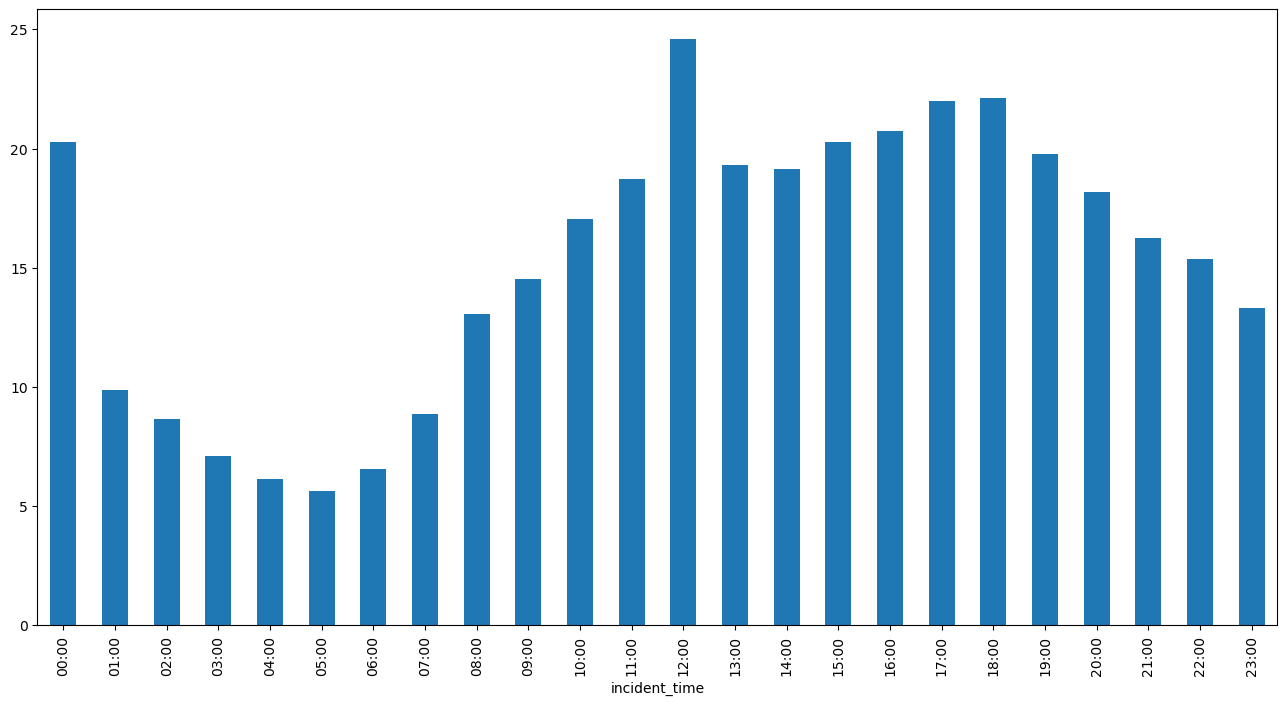

In [616]:
Grouped_SF["crime count"].groupby(Grouped_SF["incident_time"]).mean().plot(figsize=(16,8),kind="bar")

### Hourly Trend Chicago

<Axes: xlabel='incident_time'>

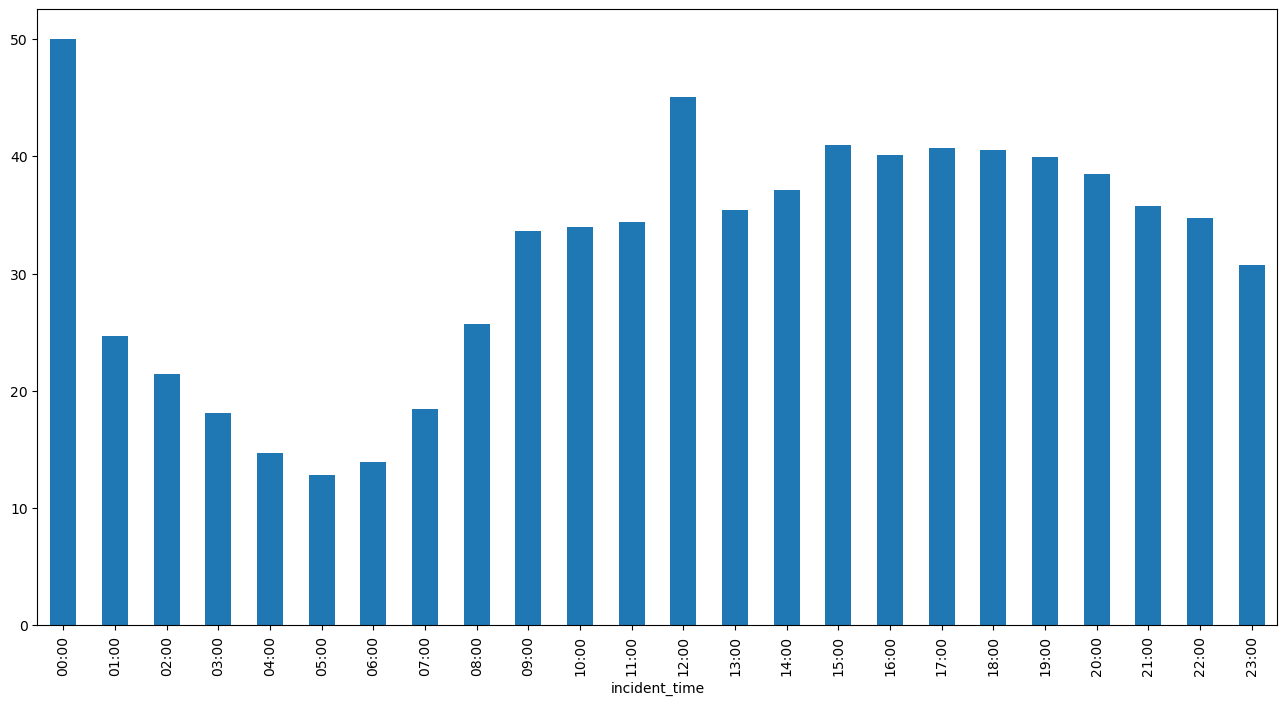

In [617]:
Grouped_Chicago["crime count"].groupby(Grouped_Chicago["incident_time"]).mean().plot(figsize=(16,8),kind="bar")

What surprised me was the fact that both of them had so similar distributions. Of course there are some differences but still they are quite alike. The lowest crime counts are both at 5 am. For the daytime, the crime counts peak at 12:00. They also have a peak at 00:00 but I think that might have something to do with when they record the data instead of when it happened. It is the initial hour of the day and that peak is a sudden peak, that is why I thought it might be the case for both cities.

### Daily Trend SF

<Axes: xlabel='incident_day_of_week'>

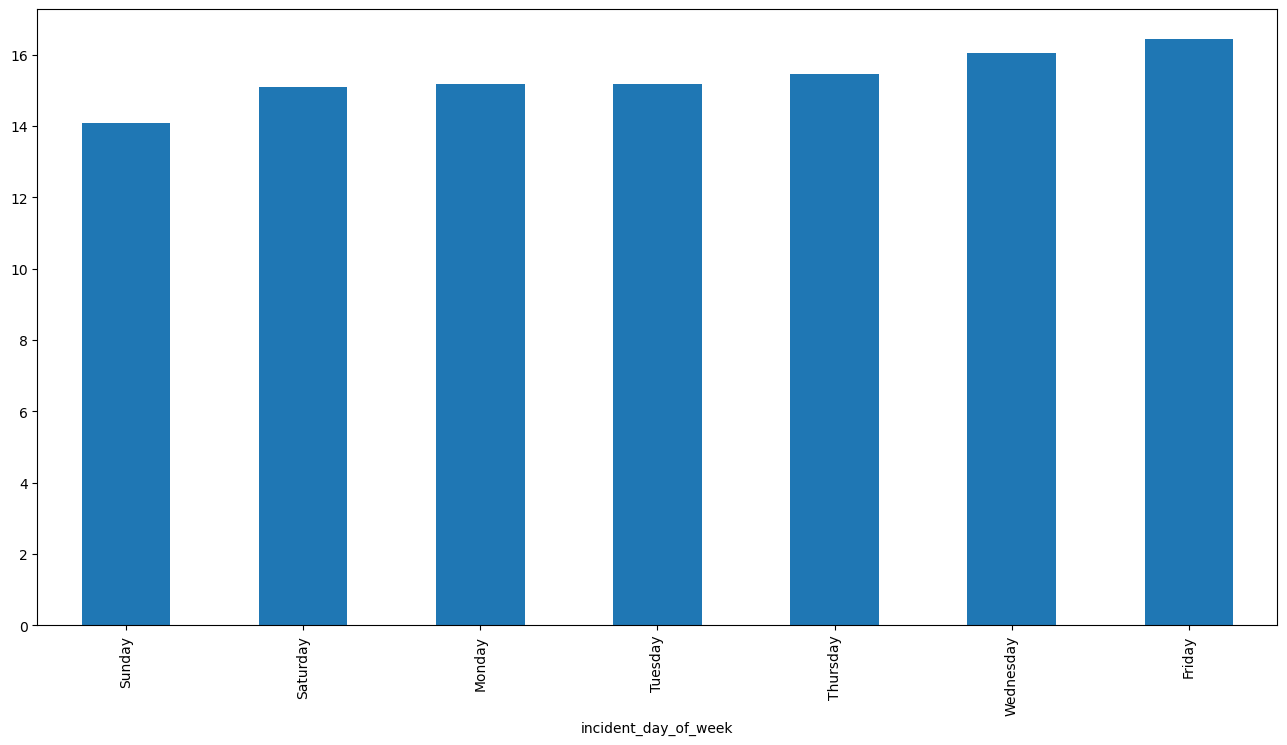

In [618]:
Grouped_SF["crime count"].groupby(Grouped_SF["incident_day_of_week"]).mean().sort_values().plot(figsize=(16,8),kind="bar")

### Daily Trend Chicago

<Axes: xlabel='incident_day_of_week'>

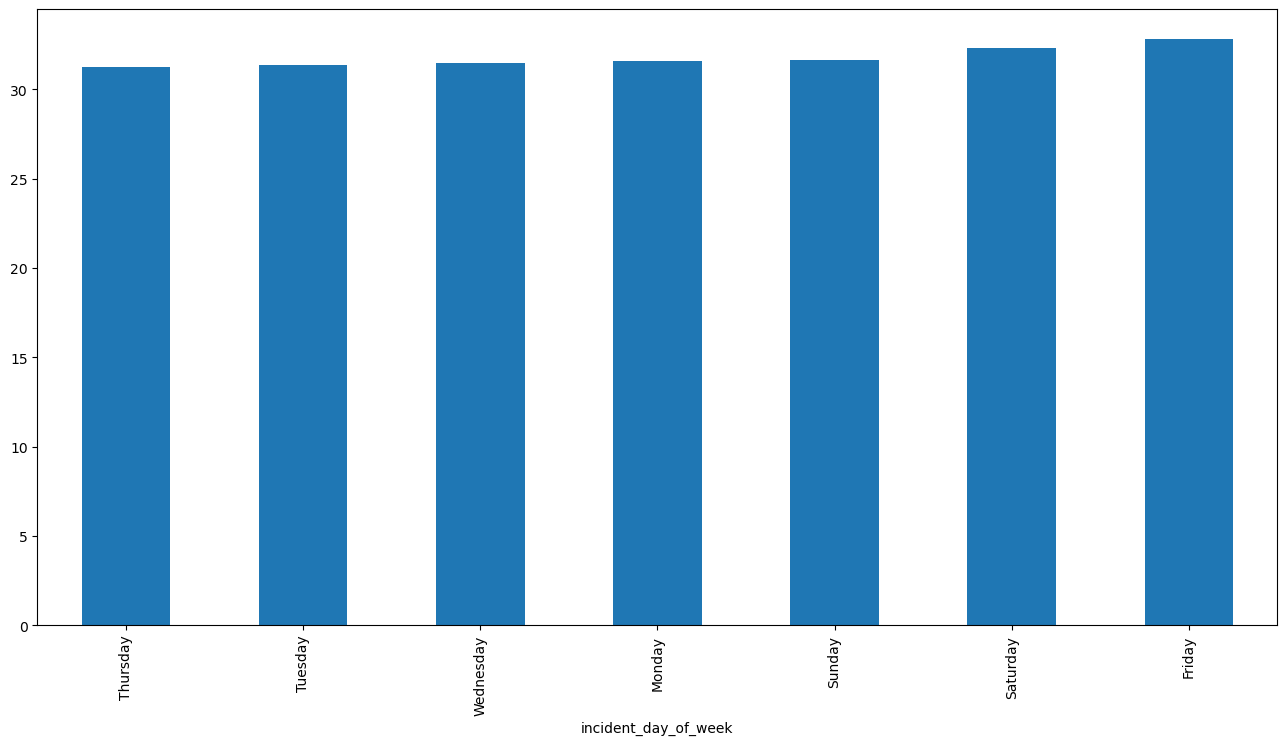

In [619]:
Grouped_Chicago["crime count"].groupby(Grouped_Chicago["incident_day_of_week"]).mean().sort_values().plot(figsize=(16,8),kind="bar")

The day with the highest crime count is "Friday" in both cities. That is interesting to see. Moreover, I had initially believed there would also be major differences with weekends but it seems that there isn't. On average, all these days are similar in terms of the sum incident counts for both cities.

### Monthly Trend SF

<Axes: xlabel='Month'>

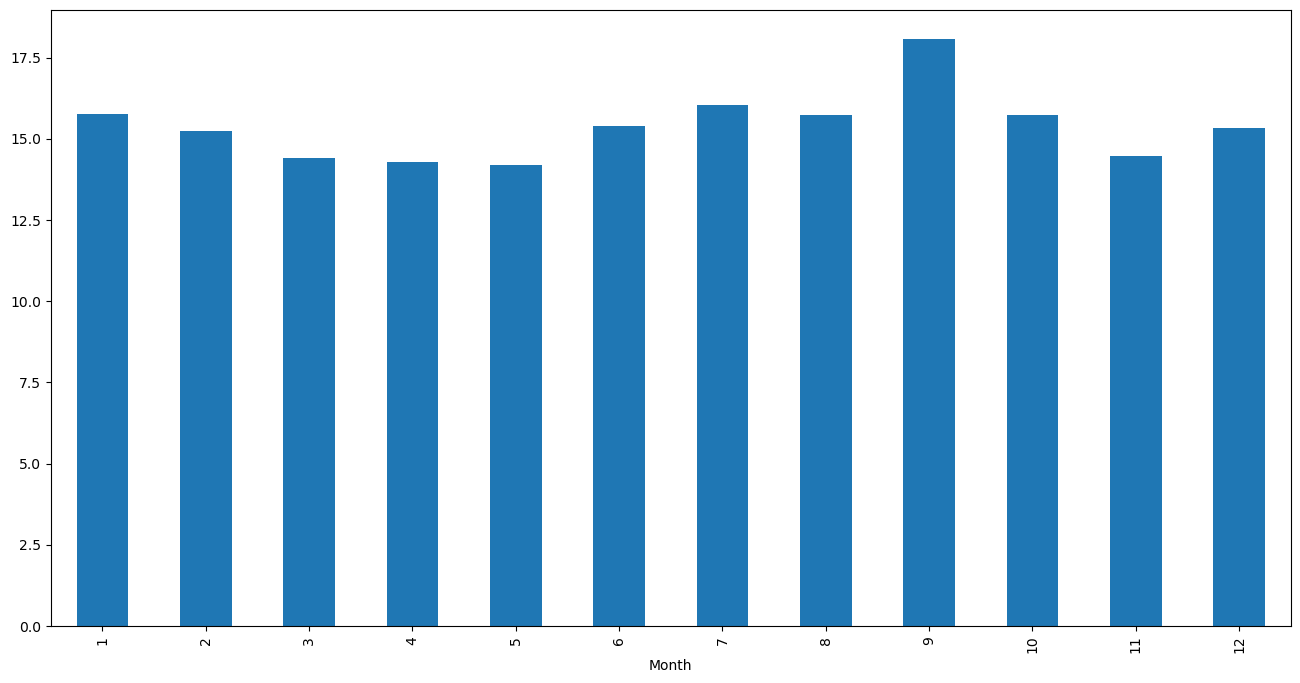

In [620]:
Grouped_SF["crime count"].groupby(Grouped_SF["Month"]).mean().sort_index().plot(figsize=(16,8),kind="bar")

### Monthly Trend Chicago

<Axes: xlabel='Month'>

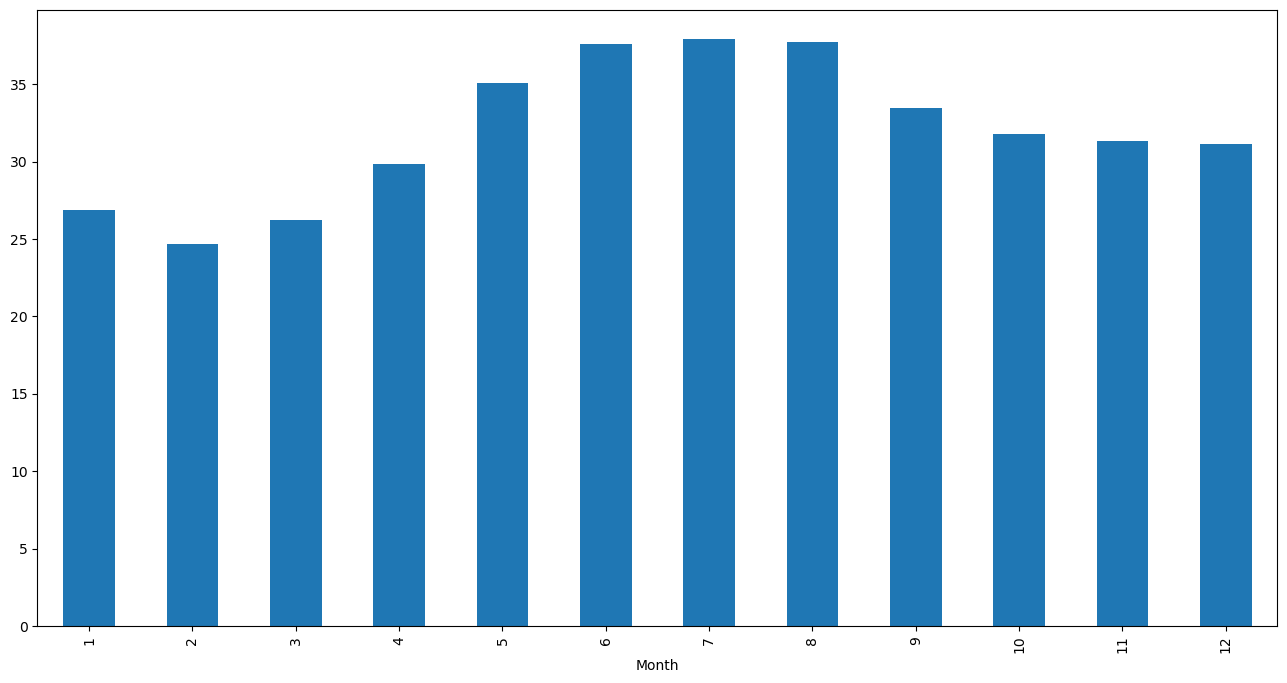

In [621]:
Grouped_Chicago["crime count"].groupby(Grouped_Chicago["Month"]).mean().sort_index().plot(figsize=(16,8),kind="bar")

This time the patterns are rather different. Chicago dataset crime counts seem to increase till summer months and then does its peak during summer. It slowly decrease after summer. On the other hand, SF has a pattern which is more fluctuating that I can't comment on as easily as the former.

## Cleaning the Weather Data 


I wrote a function to clean the weather datasets which I ingested. Those consist of precipitation and temperature for both cities. In total, this function will help me clean 4 datasets in order to easily merge and integrate them with the main frames.

In [622]:
def clean_the_weather(df):

    df['valid'] = pd.to_datetime(df['valid'])

    df['date'] = df['valid'].dt.date
    df['time'] = df['valid'].dt.time

    df["date"]=pd.to_datetime(df["date"])
    df.drop(["valid", "station"], axis=1, inplace=True)
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S')



    df['rounded_time'] = df['time'] + pd.to_timedelta(30, unit='T')  
    df['rounded_time'] = df['rounded_time'].dt.strftime('%H:%M')
    df['rounded_time'] = df['rounded_time'].str.split(':').str[0] + ':00'
    df.drop(["time"],axis=1,inplace=True)
    df['date'] = df.apply(lambda row: row['date'] + pd.DateOffset(days=1) if row['rounded_time'] == '00:00' else row['date'], axis=1)
    return df


### Cleaning and Merging the Weather Data (Temperature) for SF

In [623]:
clean_the_weather(SF_TEMP)

,tmpc,date,rounded_time
0,11.11,2018-01-01,01:00
1,10.56,2018-01-01,02:00
2,8.89,2018-01-01,03:00
3,8.33,2018-01-01,04:00
4,8.33,2018-01-01,05:00
...,...,...,...
54833,12.22,2024-04-07,20:00
54834,11.67,2024-04-07,21:00
54835,11.67,2024-04-07,22:00
54836,11.11,2024-04-07,23:00


In [624]:
merged_df_SF=pd.merge(Grouped_SF,SF_TEMP,left_on=["incident_datetime","incident_time"],right_on=["date","rounded_time"])

In [625]:
merged_df_SF

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,crime count,tmpc,date,rounded_time
0,2018-01-01,01:00,2018,Monday,1,29,11.11,2018-01-01,01:00
1,2018-01-01,02:00,2018,Monday,1,23,10.56,2018-01-01,02:00
2,2018-01-01,03:00,2018,Monday,1,15,8.89,2018-01-01,03:00
3,2018-01-01,04:00,2018,Monday,1,8,8.33,2018-01-01,04:00
4,2018-01-01,05:00,2018,Monday,1,10,8.33,2018-01-01,05:00
...,...,...,...,...,...,...,...,...,...
54422,2024-04-07,20:00,2024,Sunday,4,11,12.22,2024-04-07,20:00
54423,2024-04-07,21:00,2024,Sunday,4,8,11.67,2024-04-07,21:00
54424,2024-04-07,22:00,2024,Sunday,4,16,11.67,2024-04-07,22:00
54425,2024-04-07,23:00,2024,Sunday,4,8,11.11,2024-04-07,23:00


### Cleaning and Merging the Weather Data (Temperature) for Chicago

In [626]:
clean_the_weather(Chicago_Temp)

,tmpc,date,rounded_time
0,-18.28,2018-01-01,01:00
1,-18.89,2018-01-01,02:00
2,-19.44,2018-01-01,03:00
3,-20.00,2018-01-01,04:00
4,-20.56,2018-01-01,05:00
...,...,...,...
54872,10.56,2024-04-07,20:00
54873,10.56,2024-04-07,21:00
54874,10.00,2024-04-07,22:00
54875,10.00,2024-04-07,23:00


In [627]:
merged_df_Chicago=pd.merge(Grouped_Chicago,Chicago_Temp,left_on=["date","incident_time"],right_on=["date","rounded_time"])

In [628]:
merged_df_Chicago

,date,incident_time,incident_year,incident_day_of_week,Month,crime count,tmpc,rounded_time
0,2018-01-01,01:00,2018,Monday,1,53,-18.28,01:00
1,2018-01-01,02:00,2018,Monday,1,42,-18.89,02:00
2,2018-01-01,03:00,2018,Monday,1,36,-19.44,03:00
3,2018-01-01,04:00,2018,Monday,1,18,-20.00,04:00
4,2018-01-01,05:00,2018,Monday,1,21,-20.56,05:00
...,...,...,...,...,...,...,...,...
54622,2024-04-07,20:00,2024,Sunday,4,24,10.56,20:00
54623,2024-04-07,21:00,2024,Sunday,4,21,10.56,21:00
54624,2024-04-07,22:00,2024,Sunday,4,22,10.00,22:00
54625,2024-04-07,23:00,2024,Sunday,4,26,10.00,23:00


### Cleaning and Merging the Weather Data (Precipitation) for SF

In [629]:
clean_the_weather(SF_PREC)

,p01m,date,rounded_time
0,0.00,2018-01-01,01:00
1,0.00,2018-01-01,02:00
2,0.00,2018-01-01,03:00
3,0.00,2018-01-01,04:00
4,0.00,2018-01-01,05:00
...,...,...,...
54833,0.00,2024-04-07,20:00
54834,0.00,2024-04-07,21:00
54835,0.00,2024-04-07,22:00
54836,0.00,2024-04-07,23:00


In [630]:
merged_df_SF2=pd.merge(merged_df_SF,SF_PREC,left_on=["incident_datetime","incident_time"],right_on=["date","rounded_time"])

In [631]:
merged_df_SF2

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,crime count,tmpc,date_x,rounded_time_x,p01m,date_y,rounded_time_y
0,2018-01-01,01:00,2018,Monday,1,29,11.11,2018-01-01,01:00,0.00,2018-01-01,01:00
1,2018-01-01,02:00,2018,Monday,1,23,10.56,2018-01-01,02:00,0.00,2018-01-01,02:00
2,2018-01-01,03:00,2018,Monday,1,15,8.89,2018-01-01,03:00,0.00,2018-01-01,03:00
3,2018-01-01,04:00,2018,Monday,1,8,8.33,2018-01-01,04:00,0.00,2018-01-01,04:00
4,2018-01-01,05:00,2018,Monday,1,10,8.33,2018-01-01,05:00,0.00,2018-01-01,05:00
...,...,...,...,...,...,...,...,...,...,...,...,...
54438,2024-04-07,20:00,2024,Sunday,4,11,12.22,2024-04-07,20:00,0.00,2024-04-07,20:00
54439,2024-04-07,21:00,2024,Sunday,4,8,11.67,2024-04-07,21:00,0.00,2024-04-07,21:00
54440,2024-04-07,22:00,2024,Sunday,4,16,11.67,2024-04-07,22:00,0.00,2024-04-07,22:00
54441,2024-04-07,23:00,2024,Sunday,4,8,11.11,2024-04-07,23:00,0.00,2024-04-07,23:00


In [632]:
merged_SF2=merged_df_SF2[["incident_datetime","incident_time","incident_year","incident_day_of_week","Month","tmpc","p01m","crime count"]]
merged_SF2

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count
0,2018-01-01,01:00,2018,Monday,1,11.11,0.00,29
1,2018-01-01,02:00,2018,Monday,1,10.56,0.00,23
2,2018-01-01,03:00,2018,Monday,1,8.89,0.00,15
3,2018-01-01,04:00,2018,Monday,1,8.33,0.00,8
4,2018-01-01,05:00,2018,Monday,1,8.33,0.00,10
...,...,...,...,...,...,...,...,...
54438,2024-04-07,20:00,2024,Sunday,4,12.22,0.00,11
54439,2024-04-07,21:00,2024,Sunday,4,11.67,0.00,8
54440,2024-04-07,22:00,2024,Sunday,4,11.67,0.00,16
54441,2024-04-07,23:00,2024,Sunday,4,11.11,0.00,8


After I clean and merge the precipitation dataset, I want to assign "0" to the hours which had no rain and "1" to the hours which had rain.

In [633]:
merged_SF2["p01m"]=merged_SF2["p01m"].apply(lambda x: "0" if x=="0.00" else "1").copy()

C:\Users\erent\AppData\Local\Temp\ipykernel_14024\3371413882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_SF2["p01m"]=merged_SF2["p01m"].apply(lambda x: "0" if x=="0.00" else "1").copy()


In [634]:
merged_SF2["p01m"]=merged_SF2["p01m"].astype(int)

C:\Users\erent\AppData\Local\Temp\ipykernel_14024\1976512933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_SF2["p01m"]=merged_SF2["p01m"].astype(int)


In [635]:
merged_SF2

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count
0,2018-01-01,01:00,2018,Monday,1,11.11,0,29
1,2018-01-01,02:00,2018,Monday,1,10.56,0,23
2,2018-01-01,03:00,2018,Monday,1,8.89,0,15
3,2018-01-01,04:00,2018,Monday,1,8.33,0,8
4,2018-01-01,05:00,2018,Monday,1,8.33,0,10
...,...,...,...,...,...,...,...,...
54438,2024-04-07,20:00,2024,Sunday,4,12.22,0,11
54439,2024-04-07,21:00,2024,Sunday,4,11.67,0,8
54440,2024-04-07,22:00,2024,Sunday,4,11.67,0,16
54441,2024-04-07,23:00,2024,Sunday,4,11.11,0,8


### Cleaning and Merging the Weather Data (Precipitation) for Chicago

I will perform the same operations on the Chicago df.

In [636]:
clean_the_weather(Chicago_Prec)

,p01m,date,rounded_time
0,0.00,2018-01-01,01:00
1,0.00,2018-01-01,02:00
2,0.00,2018-01-01,03:00
3,0.00,2018-01-01,04:00
4,0.00,2018-01-01,05:00
...,...,...,...
54872,0.00,2024-04-07,20:00
54873,0.00,2024-04-07,21:00
54874,0.00,2024-04-07,22:00
54875,0.00,2024-04-07,23:00


In [637]:
merged_df_Chicago2=pd.merge(merged_df_Chicago,Chicago_Prec,left_on=["date","incident_time"],right_on=["date","rounded_time"])

In [638]:
merged_Chicago2=merged_df_Chicago2[["date","incident_time","incident_year","incident_day_of_week","Month","tmpc","p01m","crime count"]]
merged_Chicago2

,date,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count
0,2018-01-01,01:00,2018,Monday,1,-18.28,0.00,53
1,2018-01-01,02:00,2018,Monday,1,-18.89,0.00,42
2,2018-01-01,03:00,2018,Monday,1,-19.44,0.00,36
3,2018-01-01,04:00,2018,Monday,1,-20.00,0.00,18
4,2018-01-01,05:00,2018,Monday,1,-20.56,0.00,21
...,...,...,...,...,...,...,...,...
54636,2024-04-07,20:00,2024,Sunday,4,10.56,0.00,24
54637,2024-04-07,21:00,2024,Sunday,4,10.56,0.00,21
54638,2024-04-07,22:00,2024,Sunday,4,10.00,0.00,22
54639,2024-04-07,23:00,2024,Sunday,4,10.00,0.00,26


In [639]:
merged_Chicago2["p01m"]=merged_Chicago2["p01m"].apply(lambda x: "0" if x=="0.00" else "1").copy()
merged_Chicago2["p01m"]=merged_Chicago2["p01m"].astype(int)

C:\Users\erent\AppData\Local\Temp\ipykernel_14024\3847910615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_Chicago2["p01m"]=merged_Chicago2["p01m"].apply(lambda x: "0" if x=="0.00" else "1").copy()
C:\Users\erent\AppData\Local\Temp\ipykernel_14024\3847910615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_Chicago2["p01m"]=merged_Chicago2["p01m"].astype(int)


In [640]:
merged_Chicago2

,date,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count
0,2018-01-01,01:00,2018,Monday,1,-18.28,0,53
1,2018-01-01,02:00,2018,Monday,1,-18.89,0,42
2,2018-01-01,03:00,2018,Monday,1,-19.44,0,36
3,2018-01-01,04:00,2018,Monday,1,-20.00,0,18
4,2018-01-01,05:00,2018,Monday,1,-20.56,0,21
...,...,...,...,...,...,...,...,...
54636,2024-04-07,20:00,2024,Sunday,4,10.56,0,24
54637,2024-04-07,21:00,2024,Sunday,4,10.56,0,21
54638,2024-04-07,22:00,2024,Sunday,4,10.00,0,22
54639,2024-04-07,23:00,2024,Sunday,4,10.00,0,26


### Cleaning the Full Moon Dataset

Another dataset which I want to clean and merge with the main ones is "Full Moon". This will help me to see the relation with full moon and crime counts (If it exists...).

In [641]:
full_moon_df

,day,month,phase,time,year
0,2,1,Full Moon,02:24,2018
1,31,1,Full Moon,13:27,2018
2,2,3,Full Moon,00:51,2018
3,31,3,Full Moon,12:37,2018
4,30,4,Full Moon,00:58,2018
...,...,...,...,...,...
82,19,8,Full Moon,18:26,2024
83,18,9,Full Moon,02:34,2024
84,17,10,Full Moon,11:26,2024
85,15,11,Full Moon,21:28,2024


In [642]:
full_moon_df['date'] = pd.to_datetime(full_moon_df[['day', 'month', 'year']])
full_moon_df['date'] = full_moon_df['date'].dt.strftime('%Y-%m-%d')
full_moon_df.drop(['day', 'month', 'year'], axis=1, inplace=True)

In [643]:
full_moon_df

,phase,time,date
0,Full Moon,02:24,2018-01-02
1,Full Moon,13:27,2018-01-31
2,Full Moon,00:51,2018-03-02
3,Full Moon,12:37,2018-03-31
4,Full Moon,00:58,2018-04-30
...,...,...,...
82,Full Moon,18:26,2024-08-19
83,Full Moon,02:34,2024-09-18
84,Full Moon,11:26,2024-10-17
85,Full Moon,21:28,2024-11-15


In [644]:
full_moon_df["date"]=pd.to_datetime(full_moon_df["date"])

### Merging the Full Moon Dataset with SF Data, Preproccesing

In [645]:
merged_SF_3=pd.merge(merged_SF2,full_moon_df,left_on=["incident_datetime"],right_on=["date"],how="left")

I will assign 1 to all the hours of the days which had "Full Moon". Rest will be assigned with "0".

In [646]:
merged_SF_3['Full Moon'] = merged_SF_3.apply(lambda x: 1 if x['phase'] == 'Full Moon' else 0, axis=1)

In [647]:
merged_SF_3.drop(columns={"phase","time","date"},inplace=True)
merged_SF_3

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon
0,2018-01-01,01:00,2018,Monday,1,11.11,0,29,0
1,2018-01-01,02:00,2018,Monday,1,10.56,0,23,0
2,2018-01-01,03:00,2018,Monday,1,8.89,0,15,0
3,2018-01-01,04:00,2018,Monday,1,8.33,0,8,0
4,2018-01-01,05:00,2018,Monday,1,8.33,0,10,0
...,...,...,...,...,...,...,...,...,...
54438,2024-04-07,20:00,2024,Sunday,4,12.22,0,11,0
54439,2024-04-07,21:00,2024,Sunday,4,11.67,0,8,0
54440,2024-04-07,22:00,2024,Sunday,4,11.67,0,16,0
54441,2024-04-07,23:00,2024,Sunday,4,11.11,0,8,0


In [648]:
merged_SF_3[merged_SF_3["Full Moon"]==1]

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon
23,2018-01-02,00:00,2018,Tuesday,1,11.67,0,15,1
24,2018-01-02,01:00,2018,Tuesday,1,11.67,0,4,1
25,2018-01-02,02:00,2018,Tuesday,1,10.56,0,1,1
26,2018-01-02,03:00,2018,Tuesday,1,10.00,0,6,1
27,2018-01-02,04:00,2018,Tuesday,1,10.00,0,3,1
...,...,...,...,...,...,...,...,...,...
54126,2024-03-25,19:00,2024,Monday,3,12.78,0,12,1
54127,2024-03-25,20:00,2024,Monday,3,12.22,0,21,1
54128,2024-03-25,21:00,2024,Monday,3,12.22,0,14,1
54129,2024-03-25,22:00,2024,Monday,3,12.22,0,9,1


### Merging the Full Moon Dataset with Chicago Data, Preproccesing


Same for the Chicago now.

In [649]:
merged_Chicago_3=pd.merge(merged_Chicago2,full_moon_df,left_on=["date"],right_on=["date"],how="left")
merged_Chicago_3['Full Moon'] = merged_Chicago_3.apply(lambda x: 1 if x['phase'] == 'Full Moon' else 0, axis=1)
merged_Chicago_3.drop(columns={"phase","time"},inplace=True)
merged_Chicago_3

,date,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon
0,2018-01-01,01:00,2018,Monday,1,-18.28,0,53,0
1,2018-01-01,02:00,2018,Monday,1,-18.89,0,42,0
2,2018-01-01,03:00,2018,Monday,1,-19.44,0,36,0
3,2018-01-01,04:00,2018,Monday,1,-20.00,0,18,0
4,2018-01-01,05:00,2018,Monday,1,-20.56,0,21,0
...,...,...,...,...,...,...,...,...,...
54636,2024-04-07,20:00,2024,Sunday,4,10.56,0,24,0
54637,2024-04-07,21:00,2024,Sunday,4,10.56,0,21,0
54638,2024-04-07,22:00,2024,Sunday,4,10.00,0,22,0
54639,2024-04-07,23:00,2024,Sunday,4,10.00,0,26,0


In [650]:
merged_Chicago_3[merged_Chicago_3["Full Moon"]==1]

,date,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon
23,2018-01-02,00:00,2018,Tuesday,1,-20.56,0,32,1
24,2018-01-02,01:00,2018,Tuesday,1,-20.56,0,6,1
25,2018-01-02,02:00,2018,Tuesday,1,-21.11,0,14,1
26,2018-01-02,03:00,2018,Tuesday,1,-21.67,0,6,1
27,2018-01-02,04:00,2018,Tuesday,1,-22.22,0,6,1
...,...,...,...,...,...,...,...,...,...
54320,2024-03-25,19:00,2024,Monday,3,17.22,1,40,1
54321,2024-03-25,20:00,2024,Monday,3,16.67,0,35,1
54322,2024-03-25,21:00,2024,Monday,3,17.22,0,34,1
54323,2024-03-25,22:00,2024,Monday,3,14.44,1,24,1


## Is Crime Count Associated with Full Moon?
### San Fransico Incidents and Full Moon (Statistical Analysis)

To check whether there is an association, I will compare two group means. One of them will be the days with Full Moon and the other will be the days without it. I will perform independent two group t-test to find a p-value. Since I will take the whole day as a "Full Moon" day. I will group my frame by days first.

In [652]:
Full_moondf_SF=merged_SF_3[["incident_datetime","crime count","Full Moon"]].groupby("incident_datetime").agg({"crime count":"sum","Full Moon":"first"}).reset_index()
Full_moondf_SF                                           

,incident_datetime,crime count,Full Moon
0,2018-01-01,433,0
1,2018-01-02,390,1
2,2018-01-03,424,0
3,2018-01-04,468,0
4,2018-01-05,442,0
...,...,...,...
2285,2024-04-04,295,0
2286,2024-04-05,385,0
2287,2024-04-06,263,0
2288,2024-04-07,235,0


In [653]:
Full_moondf_SF.groupby(Full_moondf_SF["Full Moon"]).agg({"crime count":"mean","incident_datetime":"count"}).reset_index()

,Full Moon,crime count,incident_datetime
0,0,367.260398,2212
1,1,373.884615,78


We see a slight increase in crime count but I doubt it will be significant.

In [654]:


crime_count_full_moon_sf = Full_moondf_SF[Full_moondf_SF['Full Moon'] == 1]['crime count']
crime_count_non_full_moon_sf = Full_moondf_SF[Full_moondf_SF['Full Moon'] == 0]['crime count']


t_statistic, p_value = ttest_ind(crime_count_full_moon_sf, crime_count_non_full_moon_sf)


print("Two-sample t-test statistic:", t_statistic)
print("P-value:", p_value)

Two-sample t-test statistic: 0.6976912305887284
P-value: 0.4854412051444793


As I have guessed, the results are not significant. We can't say that the incident count has a relation with Full Moon. To be more precise: We can't reject the hypothesis that the two group means are equal with alpha=0.05.

Since t-test requires some assumptions both on the distribution and the variance of the groups, I will also use the "mannwhitneyu" test which doesn't have those assumptions. This is only for additional assesing. 

In [655]:


U_statistic, p_value = mannwhitneyu(crime_count_full_moon_sf, crime_count_non_full_moon_sf)

 
print("Mann-Whitney U test statistic:", U_statistic)
print("P-value:", p_value)

Mann-Whitney U test statistic: 90053.5
P-value: 0.5095790181784299


Results are quite far away from being significant.

### Chicago Incidents and Full Moon (Statistical Analysis)

I will do the same statistical tests on Chicago set now.

In [656]:
Full_moondf_Chicago=merged_Chicago_3[["date","crime count","Full Moon"]].groupby("date").agg({"crime count":"sum","Full Moon":"first"}).reset_index()
Full_moondf_Chicago

,date,crime count,Full Moon
0,2018-01-01,750,0
1,2018-01-02,604,1
2,2018-01-03,620,0
3,2018-01-04,649,0
4,2018-01-05,708,0
...,...,...,...
2285,2024-04-04,611,0
2286,2024-04-05,643,0
2287,2024-04-06,697,0
2288,2024-04-07,611,0


In [657]:
Full_moondf_Chicago.groupby(Full_moondf_Chicago["Full Moon"]).agg({"crime count":"mean","date":"count"}).reset_index()

,Full Moon,crime count,date
0,0,759.849458,2212
1,1,763.923077,78


In [658]:

crime_count_full_moon_chicago = Full_moondf_Chicago[Full_moondf_Chicago['Full Moon'] == 1]['crime count']
crime_count_non_full_moon_chicago = Full_moondf_Chicago[Full_moondf_Chicago['Full Moon'] == 0]['crime count']


t_statistic, p_value = ttest_ind(crime_count_full_moon_chicago, crime_count_non_full_moon_chicago)


print("Two-sample t-test statistic:", t_statistic)
print("P-value:", p_value)

Two-sample t-test statistic: 0.11980365678200369
P-value: 0.9046492033437782


Again, one can't say that there is a relation with full moon dates and the crime counts. 

In [659]:

U_statistic, p_value = mannwhitneyu(crime_count_full_moon_chicago, crime_count_non_full_moon_chicago)

 
print("Mann-Whitney U test statistic:", U_statistic)
print("P-value:", p_value)

Mann-Whitney U test statistic: 86689.0
P-value: 0.9415940537432355


Mann-Whitney U test statistic also proves the previous point.

## Is Crime Count Associated with Precipitation?
### San Francisco Incidents and Hourly Precipitation 

In [660]:
cross_tab_mean_sf = pd.crosstab(index=merged_SF_3['incident_time'], columns=merged_SF_3['p01m'].map({0: 'No Rain', 1: 'Rain'}), values=merged_SF_3['crime count'], aggfunc='mean')


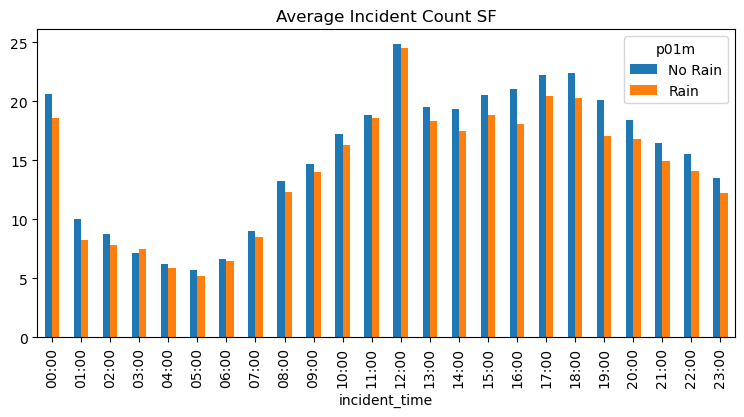

In [661]:
gra=cross_tab_mean_sf.plot(kind='bar', stacked=False,figsize=(9,4))
gra.set_title("Average Incident Count SF")

plt.show()

This is interesting to see. Almost all hours had lower incident counts when it rained in SF. I will also try statistically backing my results.

In [662]:
Stat_SF_prec=merged_SF_3[["incident_time","crime count","p01m"]].copy()

In [663]:
Stat_SF_prec_with_rain=Stat_SF_prec[Stat_SF_prec["p01m"]==1]
Stat_SF_prec_without_rain=Stat_SF_prec[Stat_SF_prec["p01m"]==0]

I want to test each hour to find whether there is a relation with crime counts and the rain. I will write a function to be able to use it for both of the cities. It will return the p-values for each hour and it will help me a lot in my statistical analysis.

In [664]:
def compare_hourly_statistics_crime_counts(data_with_rain, data_without_rain):
    hourly_results = {}
    hours = ["{:02d}:00".format(hour) for hour in range(24)]
    
    for hour in hours:
        crime_count_with_rain = data_with_rain[data_with_rain["incident_time"] == hour]["crime count"]
        crime_count_without_rain = data_without_rain[data_without_rain["incident_time"] == hour]["crime count"]
        
        t_statistic, p_value = ttest_ind(crime_count_with_rain, crime_count_without_rain)
        
        hourly_results[hour] = {"t_statistic": t_statistic, "p_value": p_value}
    
    return hourly_results




In [665]:
hourly_comparison_sf_rain = compare_hourly_statistics_crime_counts(Stat_SF_prec_with_rain, Stat_SF_prec_without_rain)

In [666]:
pd.DataFrame(hourly_comparison_sf_rain).T

,t_statistic,p_value
00:00,-2.468248,0.013650
01:00,-4.160247,0.000033
02:00,-2.317345,0.020573
03:00,0.978723,0.327822
04:00,-0.991668,0.321467
05:00,-2.004660,0.045120
06:00,-0.579426,0.562360
07:00,-1.255728,0.209345
08:00,-1.883563,0.059752
09:00,-1.396035,0.162840


The results are not what I expected but I found them really informative. For all hours between 14:00 to 02:00 AM, there is a significant relation with crime counts and the rain. For others, the results don't look significant. One might say that the rain can be associated with incident counts from afternoon to late night but after that it can't be. 

### Chicago Incidents and Hourly Precipitation 

In [667]:
cross_tab_mean_chicago = pd.crosstab(index=merged_Chicago_3['incident_time'], columns=merged_Chicago_3['p01m'].map({0: 'No Rain', 1: 'Rain'}), values=merged_Chicago_3['crime count'], aggfunc='mean')


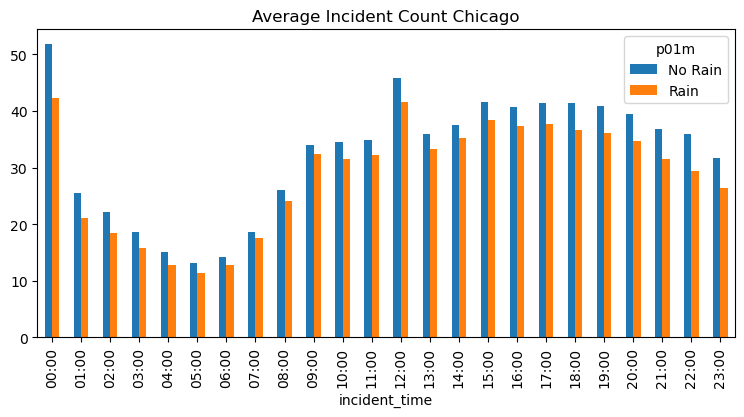

In [668]:
gra=cross_tab_mean_chicago.plot(kind='bar', stacked=False,figsize=(9,4))
gra.set_title("Average Incident Count Chicago")

plt.show()

Again, a similar result to SF. This time all hours had lower incident counts when there was rain. I will asses its significance with the function I created earlier.

In [669]:
Stat_Chicago_prec=merged_Chicago_3[["incident_time","crime count","p01m"]].copy()
Stat_Chicago_prec_with_rain=Stat_Chicago_prec[Stat_Chicago_prec["p01m"]==1]
Stat_Chicago_prec_without_rain=Stat_Chicago_prec[Stat_Chicago_prec["p01m"]==0]

In [670]:
hourly_comparison_chicago_rain = compare_hourly_statistics_crime_counts(Stat_Chicago_prec_with_rain, Stat_Chicago_prec_without_rain)
pd.DataFrame(hourly_comparison_chicago_rain)

,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,09:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
t_statistic,-5.651974e+00,-5.662148e+00,-4.951625e+00,-4.350087,-4.651710,-3.960389,-3.525264,-1.948092,-2.752265,-1.950848,...,-2.494014,-3.178972,-3.391277,-3.991243,-4.964751e+00,-5.206997e+00,-5.313653e+00,-5.958883e+00,-7.520384e+00,-6.340964e+00
p_value,1.784150e-08,1.684885e-08,7.899630e-07,0.000014,0.000003,0.000077,0.000432,0.051527,0.005965,0.051197,...,0.012701,0.001498,0.000708,0.000068,7.387161e-07,2.091147e-07,1.178893e-07,2.933497e-09,7.807394e-14,2.744425e-10


This time it can be said that all hours except 07:00 can be counted as significant in terms of incident counts being associated with rain. (considering we choose alpha=0.05)

### Does crime count have an association with Daily Temperatures? - SF

For the temperature I decided on checking the correlation. I will also check the feature importance of the "temperature" feature when I will be modeling tree based algorithms.

In [671]:
merged_SF_3['tmpc'].fillna(method='ffill', inplace=True)


In [672]:
merged_SF_3[["tmpc","crime count"]].groupby(merged_SF_3["incident_datetime"]).agg({"tmpc":"mean","crime count":"sum"}).corr()

,tmpc,crime count
tmpc,1.000000,0.075673
crime count,0.075673,1.000000


### Does crime count have an association with Daily Temperatures? - Chicago

In [673]:
merged_Chicago_3['tmpc'].replace('M', np.nan, inplace=True)

merged_Chicago_3['tmpc'].fillna(method='ffill', inplace=True)

merged_Chicago_3['tmpc'] = merged_Chicago_3['tmpc'].astype(float)

In [674]:
merged_Chicago_3[["tmpc","crime count"]].groupby(merged_Chicago_3["date"]).agg({"tmpc":"mean","crime count":"sum"}).corr()

,tmpc,crime count
tmpc,1.000000,0.369528
crime count,0.369528,1.000000


Both of the cities showed a positive correlation. What amazed me was the high correlation in Chicago.

## How does the Incident Count Change during Public Holidays?

I was also curious to see how the counts changed during public holidays. Python's holiday library was perfect for me. I will start by ingesting and cleaning it.

In [675]:
us_holidays = []

for year in range(2018, 2025):
    holidays_for_year = getattr(holidays.UnitedStates(years=year), 'items')()
    
    us_holidays.extend(holidays_for_year)

holiday_df = pd.DataFrame(us_holidays, columns=['Date', 'Holiday'])


In [676]:
holiday_df["Date"]=pd.to_datetime(holiday_df["Date"])

In [677]:
holiday_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     84 non-null     datetime64[ns]
 1   Holiday  84 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.4+ KB


### SF on Public Holidays

I will merge it with my main dataset of SF. Then I will group it by days. I want to see the crime counts for each holiday. 

In [678]:
merged_SF4=pd.merge(merged_SF_3,holiday_df,left_on=["incident_datetime"],right_on=["Date"],how="left")

In [679]:
grouped_for_holidays_sf=merged_SF4[["crime count","Holiday"]].groupby(merged_SF4["incident_datetime"]).agg({"crime count":"sum","Holiday":"first"}).copy().reset_index()
grouped_for_holidays_sf

,incident_datetime,crime count,Holiday
0,2018-01-01,433,New Year's Day
1,2018-01-02,390,None
2,2018-01-03,424,None
3,2018-01-04,468,None
4,2018-01-05,442,None
...,...,...,...
2285,2024-04-04,295,None
2286,2024-04-05,385,None
2287,2024-04-06,263,None
2288,2024-04-07,235,None


In [680]:
grouped_for_holidays_sf["crime count"].groupby(grouped_for_holidays_sf["Holiday"]).mean().sort_values()

Holiday
Veterans Day (observed)                            224.500000
Thanksgiving                                       230.166667
Christmas Day                                      269.000000
Christmas Day (observed)                           309.000000
Veterans Day                                       317.500000
Juneteenth National Independence Day               330.333333
New Year's Day (observed)                          332.500000
Martin Luther King Jr. Day                         342.142857
Memorial Day                                       350.166667
Independence Day                                   356.166667
Washington's Birthday                              358.428571
Columbus Day                                       374.833333
Independence Day (observed)                        379.000000
Juneteenth National Independence Day (observed)    429.000000
Labor Day                                          435.833333
New Year's Day                                     520.285714


New Year's Day was the day with the highest average crime counts. This is interesting to see. Veterans Day, Thanksgiving and also the Christmas was low incident holidays. 

In [681]:
merged_SF4.drop("Date", axis=1, inplace=True)


I will do the same as I did in Full Moon. I will replace the days with holiday with 1 and the rest with 0 to perform statistical analysis.

In [682]:

merged_SF4["Holiday"] = merged_SF4["Holiday"].fillna(0).apply(lambda x: 1 if x != 0 else 0)
merged_SF4

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon,Holiday
0,2018-01-01,01:00,2018,Monday,1,11.11,0,29,0,1
1,2018-01-01,02:00,2018,Monday,1,10.56,0,23,0,1
2,2018-01-01,03:00,2018,Monday,1,8.89,0,15,0,1
3,2018-01-01,04:00,2018,Monday,1,8.33,0,8,0,1
4,2018-01-01,05:00,2018,Monday,1,8.33,0,10,0,1
...,...,...,...,...,...,...,...,...,...,...
54438,2024-04-07,20:00,2024,Sunday,4,12.22,0,11,0,0
54439,2024-04-07,21:00,2024,Sunday,4,11.67,0,8,0,0
54440,2024-04-07,22:00,2024,Sunday,4,11.67,0,16,0,0
54441,2024-04-07,23:00,2024,Sunday,4,11.11,0,8,0,0


In [683]:
holiday_df_SF=merged_SF4[["incident_datetime","crime count","Holiday"]].groupby("incident_datetime").agg({"crime count":"sum","Holiday":"first"}).reset_index()
holiday_df_SF.groupby(holiday_df_SF["Holiday"]).agg({"crime count":"mean","incident_datetime":"count"}).reset_index()

,Holiday,crime count,incident_datetime
0,0,367.956640,2214
1,1,353.776316,76


In [684]:

crime_count_holiday_sf = holiday_df_SF[holiday_df_SF['Holiday'] == 1]['crime count']
crime_count_no_holiday_sf = holiday_df_SF[holiday_df_SF['Holiday'] == 0]['crime count']


t_statistic, p_value = ttest_ind(crime_count_holiday_sf, crime_count_no_holiday_sf)


print("Two-sample t-test statistic:", t_statistic)
print("P-value:", p_value)


Two-sample t-test statistic: -1.4754717155219255
P-value: 0.14022336161737087


In [685]:

U_statistic, p_value = mannwhitneyu(crime_count_holiday_sf, crime_count_no_holiday_sf)

 
print("Mann-Whitney U test statistic:", U_statistic)
print("P-value:", p_value)

Mann-Whitney U test statistic: 75222.0
P-value: 0.11595929655977966


These finding tell me that I can't say my values are significant. Basically I can't say that there is an association between holidays and incident counts.

### Chicago on Public Holidays

In [686]:
merged_Chicago_4=pd.merge(merged_Chicago_3,holiday_df,left_on=["date"],right_on=["Date"],how="left")
grouped_for_holidays_chicago=merged_Chicago_4[["crime count","Holiday"]].groupby(merged_Chicago_4["date"]).agg({"crime count":"sum","Holiday":"first"}).copy().reset_index()
grouped_for_holidays_chicago

,date,crime count,Holiday
0,2018-01-01,750,New Year's Day
1,2018-01-02,604,None
2,2018-01-03,620,None
3,2018-01-04,649,None
4,2018-01-05,708,None
...,...,...,...
2285,2024-04-04,611,None
2286,2024-04-05,643,None
2287,2024-04-06,697,None
2288,2024-04-07,611,None


In [687]:
grouped_for_holidays_chicago["crime count"].groupby(grouped_for_holidays_chicago["Holiday"]).mean().sort_values()

Holiday
Christmas Day (observed)                            389.000000
New Year's Day (observed)                           453.000000
Martin Luther King Jr. Day                          525.714286
Washington's Birthday                               538.571429
Christmas Day                                       558.666667
Thanksgiving                                        565.833333
Veterans Day                                        684.500000
Columbus Day                                        735.166667
Independence Day (observed)                         879.500000
Labor Day                                           886.166667
Memorial Day                                        905.500000
Independence Day                                    970.166667
New Year's Day                                     1027.714286
Veterans Day (observed)                            1064.500000
Juneteenth National Independence Day (observed)    1066.500000
Juneteenth National Independence Day           

This time Juneteenth National Independence Day is the average incident count leader. It might be important to mention that New Year's day is once again high in crime.

In [688]:
merged_Chicago_4

,date,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon,Date,Holiday
0,2018-01-01,01:00,2018,Monday,1,-18.28,0,53,0,2018-01-01,New Year's Day
1,2018-01-01,02:00,2018,Monday,1,-18.89,0,42,0,2018-01-01,New Year's Day
2,2018-01-01,03:00,2018,Monday,1,-19.44,0,36,0,2018-01-01,New Year's Day
3,2018-01-01,04:00,2018,Monday,1,-20.00,0,18,0,2018-01-01,New Year's Day
4,2018-01-01,05:00,2018,Monday,1,-20.56,0,21,0,2018-01-01,New Year's Day
...,...,...,...,...,...,...,...,...,...,...,...
54636,2024-04-07,20:00,2024,Sunday,4,10.56,0,24,0,NaT,NaN
54637,2024-04-07,21:00,2024,Sunday,4,10.56,0,21,0,NaT,NaN
54638,2024-04-07,22:00,2024,Sunday,4,10.00,0,22,0,NaT,NaN
54639,2024-04-07,23:00,2024,Sunday,4,10.00,0,26,0,NaT,NaN


I will perform the same operations I did for the SF set in order to statistically analyze my results.

In [689]:
merged_Chicago_4.drop("Date", axis=1, inplace=True)

merged_Chicago_4["Holiday"] = merged_Chicago_4["Holiday"].fillna(0).apply(lambda x: 1 if x != 0 else 0)
merged_Chicago_4

,date,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon,Holiday
0,2018-01-01,01:00,2018,Monday,1,-18.28,0,53,0,1
1,2018-01-01,02:00,2018,Monday,1,-18.89,0,42,0,1
2,2018-01-01,03:00,2018,Monday,1,-19.44,0,36,0,1
3,2018-01-01,04:00,2018,Monday,1,-20.00,0,18,0,1
4,2018-01-01,05:00,2018,Monday,1,-20.56,0,21,0,1
...,...,...,...,...,...,...,...,...,...,...
54636,2024-04-07,20:00,2024,Sunday,4,10.56,0,24,0,0
54637,2024-04-07,21:00,2024,Sunday,4,10.56,0,21,0,0
54638,2024-04-07,22:00,2024,Sunday,4,10.00,0,22,0,0
54639,2024-04-07,23:00,2024,Sunday,4,10.00,0,26,0,0


In [690]:
holiday_df_Chicago=merged_Chicago_4[["date","crime count","Holiday"]].groupby("date").agg({"crime count":"sum","Holiday":"first"}).reset_index()
holiday_df_Chicago.groupby(holiday_df_Chicago["Holiday"]).agg({"crime count":"mean","date":"count"}).reset_index()

,Holiday,crime count,date
0,0,760.074526,2214
1,1,757.473684,76


In [691]:
crime_count_holiday_chicago = holiday_df_Chicago[holiday_df_Chicago['Holiday'] == 1]['crime count']
crime_count_no_holiday_chicago = holiday_df_Chicago[holiday_df_Chicago['Holiday'] == 0]['crime count']


t_statistic, p_value = ttest_ind(crime_count_holiday_chicago, crime_count_no_holiday_chicago)


print("Two-sample t-test statistic:", t_statistic)
print("P-value:", p_value)


Two-sample t-test statistic: -0.07553677436034936
P-value: 0.9397942431427452


In [692]:
U_statistic, p_value = mannwhitneyu(crime_count_holiday_chicago, crime_count_no_holiday_chicago)

 
print("Mann-Whitney U test statistic:", U_statistic)
print("P-value:", p_value)

Mann-Whitney U test statistic: 80514.0
P-value: 0.523309628649578


There is no significant relation with incident counts and holidays for Chicago as well.

## Modeling to Predict Hourly Incident Counts

### Preproccesing the Datasets 
I will write a function to encode the neccesary columns and merge it with other features to have the final dataset, ready to be trained. I used one-hot encoding here for all my categorical columns. I had also tried cyclic encoding for the hour column but I didn't like my results. I dropped the first category of each feature when encoding, in order to ensure I don't have any trouble with multicollinearity due to that particular reason. This was a must, especially if I decided to train with linear regression. 

In [693]:
def encode_split_dataset(dataset):
    hour_dummies = pd.get_dummies(dataset['incident_time'], prefix='hour', drop_first=True)
    month_dummies = pd.get_dummies(dataset['Month'], prefix='month', drop_first=True)
    year_dummies = pd.get_dummies(dataset['incident_year'], prefix='year', drop_first=True)
    
    encoded_data = pd.concat([dataset[['tmpc', 'p01m', 'Full Moon', 'Holiday', 'crime count']], 
                              hour_dummies, month_dummies, year_dummies], axis=1)
    
    X = encoded_data.drop("crime count", axis=1)
    y = encoded_data["crime count"]
    
    return X, y


### Choosing the Right Stratification Method

Before I write my validation function, I wanted to decide on how I would perform the splitting of the validation set. I could have done it completely randomly however, I believe that this is not a good idea since my data has temporal dependencies. As I have shown before, the crime count(the target in my case) values are heavily dependant on the hour. That is why I believe it is more reasonable to keep the hour distribution similar in both test and the train set. This will also help ensuring both subsets to have similar distributions in terms of my target.  

After deciding on using "the hour" column to stratify, I also wanted to see whether there are temporal patterns in "the year" column. What I found was the fact that yearly changes can be considered significant on the "crime counts". Therefore, I also wanted to include this column as a second to "hour" in my stratification.  

Below, I performed what I was talking about. It was just to see how the distributions were correctly handled, I also used the very same spliting method in my modeling in the next section. This was only to asses the split. I used the Chicago Dataset for this example. 

In [694]:
X, y = encode_split_dataset(merged_Chicago_4)


hour = merged_Chicago_4['incident_time']
year = merged_Chicago_4['incident_year']

stratify_var = hour.astype(str) + '_' + year.astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=stratify_var, test_size=0.2, random_state=45)

hour_train = hour.iloc[X_train.index]
hour_test = hour.iloc[X_test.index]
year_train = year.iloc[X_train.index]
year_test = year.iloc[X_test.index]

train_hour_distribution = hour_train.value_counts(normalize=True)
test_hour_distribution = hour_test.value_counts(normalize=True)
train_year_distribution = year_train.value_counts(normalize=True)
test_year_distribution = year_test.value_counts(normalize=True)

print("Training set hour distribution:")
print(train_hour_distribution)
print("\nTest set hour distribution:")
print(test_hour_distribution)

print("\nTraining set year distribution:")
print(train_year_distribution)
print("\nTest set year distribution:")
print(test_year_distribution)

Training set hour distribution:
incident_time
18:00    0.041865
12:00    0.041865
15:00    0.041865
21:00    0.041865
11:00    0.041865
13:00    0.041842
09:00    0.041842
17:00    0.041842
14:00    0.041819
16:00    0.041819
00:00    0.041796
10:00    0.041773
19:00    0.041751
23:00    0.041751
20:00    0.041751
22:00    0.041728
02:00    0.041705
08:00    0.041705
07:00    0.041568
01:00    0.041407
04:00    0.041202
06:00    0.041156
05:00    0.041133
03:00    0.041087
Name: proportion, dtype: float64

Test set hour distribution:
incident_time
20:00    0.041907
14:00    0.041907
12:00    0.041907
10:00    0.041815
13:00    0.041815
17:00    0.041815
15:00    0.041815
18:00    0.041815
22:00    0.041815
19:00    0.041815
08:00    0.041815
00:00    0.041815
11:00    0.041815
21:00    0.041815
16:00    0.041815
09:00    0.041724
02:00    0.041724
23:00    0.041724
07:00    0.041632
01:00    0.041266
04:00    0.041175
03:00    0.041083
06:00    0.041083
05:00    0.041083
Name: proporti

### Modeling and Validating the Model

I wanted to asses the model based on confidence intervals of the metrics, rather than looking at single numbers. For this, the method I choose was bootsraping. I had written the code for it before I wrote the main modeling function. It can be found below.

I decided on performing train-test splitting with stratification by the hour and the year features n times with different seeds for randomness each time. I believe this way of validation is the best method for these datasets.

In [695]:
def bootstrap_confidence_interval(data, num_bootstrap_samples=1000, confidence_level=0.95):
    bootstrap_samples = [np.mean(resample(data)) for _ in range(num_bootstrap_samples)]
    lower_bound = np.percentile(bootstrap_samples, ((1 - confidence_level) / 2) * 100)
    upper_bound = np.percentile(bootstrap_samples, (1 - (1 - confidence_level) / 2) * 100)
    return lower_bound, upper_bound

This function is where I perform everything related to modeling. It inputs the independent and dependent variables, stratification method, how many iteration of splits I will perform (cruical for creating the confidence intervals), bootstrapling sample size(I went with 1000 since it is the most common), also the confidence level to create the intervals in bootstraping function. 

It returns two dataframes. First one consists of the metric results for R^2, MSE and the time mean training time along with all their confidence intervals. Second one is for creating the feature importances for the models which have that method(Tree Based Models). I also calculated their confidence intervals for every single feature as well. It outputs them in decreasing order by the mean feature importance.  

In [696]:
def Model_and_Validate(X, y, model, stratification, n=15, num_bootstrap_samples=1000, confidence_level=0.95):
    r2list = []
    mselist = []
    featureimportanceslist = []
    training_timelist = []

    for i in range(n):
        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=stratification, test_size=0.2, random_state=45+i)
        model.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time
        training_timelist.append(training_time)
        
        y_pred = model.predict(X_test)
        mselist.append(mean_squared_error(y_test, y_pred))
        r2list.append(r2_score(y_test, y_pred))
        if hasattr(model, 'feature_importances_'):
            featureimportanceslist.append(model.feature_importances_)
    
    r2array = np.array(r2list)
    msearray = np.array(mselist)
    training_timearray = np.array(training_timelist)
    
    r2_mean = np.mean(r2array)
    mse_mean = np.mean(msearray)
    training_time_mean = np.mean(training_timearray)
    
    ci_r2 = bootstrap_confidence_interval(r2array, num_bootstrap_samples, confidence_level)
    ci_mse = bootstrap_confidence_interval(msearray, num_bootstrap_samples, confidence_level)
    ci_training_time = bootstrap_confidence_interval(training_timearray, num_bootstrap_samples, confidence_level)
    
    summary_df = pd.DataFrame({
        'Metric': ['R^2', 'MSE', 'Training Time'],
        'Mean': [r2_mean, mse_mean, training_time_mean],
        'Confidence Interval Lower Bound': [ci_r2[0], ci_mse[0], ci_training_time[0]],
        'Confidence Interval Upper Bound': [ci_r2[1], ci_mse[1], ci_training_time[1]]
    })
    
    featureimportancesarray = np.array(featureimportanceslist)
    if featureimportancesarray.size > 0:
        feature_importances_mean = np.mean(featureimportancesarray, axis=0)
        ci_feature_importances = np.array([bootstrap_confidence_interval(featureimportancesarray[:, i], num_bootstrap_samples, confidence_level)
                                       for i in range(feature_importances_mean.shape[0])])

        feature_importances_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance Mean': feature_importances_mean,
            'Importance CI Lower': ci_feature_importances[:, 0],
            'Importance CI Upper': ci_feature_importances[:, 1]
        }).sort_values(by='Importance Mean', ascending=False).reset_index(drop=True)
    else:
        feature_importances_df = None
    
    return summary_df, feature_importances_df

### Modeling the San Francisco Data



In [819]:
merged_SF4

,incident_datetime,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon,Holiday
0,2018-01-01,01:00,2018,Monday,1,11.11,0,29,0,1
1,2018-01-01,02:00,2018,Monday,1,10.56,0,23,0,1
2,2018-01-01,03:00,2018,Monday,1,8.89,0,15,0,1
3,2018-01-01,04:00,2018,Monday,1,8.33,0,8,0,1
4,2018-01-01,05:00,2018,Monday,1,8.33,0,10,0,1
...,...,...,...,...,...,...,...,...,...,...
54438,2024-04-07,20:00,2024,Sunday,4,12.22,0,11,0,0
54439,2024-04-07,21:00,2024,Sunday,4,11.67,0,8,0,0
54440,2024-04-07,22:00,2024,Sunday,4,11.67,0,16,0,0
54441,2024-04-07,23:00,2024,Sunday,4,11.11,0,8,0,0


I will encode and split the dataset with the function I created earlier. Then I will create the stratification df for San Francisco.

In [697]:
X_sf, y_sf = encode_split_dataset(merged_SF4)


hour_sf = merged_SF4['incident_time']
year_sf = merged_SF4['incident_year']
stratify_var_sf = hour_sf.astype(str) + '_' + year_sf.astype(str)


### Linear Regression - San Francisco

I will start with trying a linear regression model. Since it doesn't have feature_importances method I won't be using that part of the code (I assigned null to blank_feature_importances). -- I also didn't do an ANOVA analyis because most of my data is one-hot-encoded. I found it harder to interpret.

In [698]:
Results, blank_feature_importances=Model_and_Validate(X_sf,y_sf,LinearRegression(),stratify_var_sf,n=15)

In [699]:
Results

,Metric,Mean,Confidence Interval Lower Bound,Confidence Interval Upper Bound
0,R^2,0.458927,0.455682,0.462723
1,MSE,41.392129,40.901919,41.888506
2,Training Time,0.171231,0.158118,0.183898


To be honest, my function is not designed to work great with LR. I intentionally designed it to give the best looking outputs in tree based models. I did it because I believed both of my datasets contain lots of featural non-linear relations with target. However, I also added the option to train the data with LR to see it's performance. Looking at the MSE, I dont think it did a bad job. I will try some regularization now.

In [700]:
Results,blank_feature_importances=Model_and_Validate(X_sf,y_sf,Lasso(),stratify_var_sf,n=15)

In [701]:
Results

,Metric,Mean,Confidence Interval Lower Bound,Confidence Interval Upper Bound
0,R^2,0.099706,0.097792,0.101757
1,MSE,68.866952,68.261055,69.473735
2,Training Time,0.189501,0.177543,0.202149


In [702]:
Results, blank_feature_importances=Model_and_Validate(X_sf,y_sf,Ridge(),stratify_var_sf,n=15)

In [703]:
Results

,Metric,Mean,Confidence Interval Lower Bound,Confidence Interval Upper Bound
0,R^2,0.458942,0.455634,0.462810
1,MSE,41.391060,40.848246,41.865181
2,Training Time,0.146161,0.133670,0.157886


### Decision Tree - San Francisco

Now, I am going to try a decision tree model.

In [704]:
Results, Feature_Importances=Model_and_Validate(X_sf,y_sf,DecisionTreeRegressor(),stratify_var_sf,n=15)

In [705]:
Results

,Metric,Mean,Confidence Interval Lower Bound,Confidence Interval Upper Bound
0,R^2,0.197751,0.189367,0.206491
1,MSE,61.371588,60.485266,62.332476
2,Training Time,0.390335,0.380338,0.401256


MSE and R^2 did a worse job than LR. I will check the feature importances with their confidence intervals now.

In [706]:
Feature_Importances.head(10)

,Feature,Importance Mean,Importance CI Lower,Importance CI Upper
0,tmpc,0.249009,0.247586,0.250388
1,hour_06:00,0.051716,0.051401,0.052072
2,hour_03:00,0.051696,0.051399,0.051989
3,hour_05:00,0.051495,0.051155,0.051862
4,hour_04:00,0.050950,0.050595,0.051382
5,hour_07:00,0.043575,0.043317,0.043869
6,hour_02:00,0.042153,0.041843,0.042422
7,hour_01:00,0.040374,0.040007,0.040753
8,year_2023,0.039380,0.037392,0.041196
9,hour_12:00,0.030744,0.030266,0.031180


My model is not good at explaining the variability in the target(crime counts). The MSE doesn't look that bad but still, I will try to train better models now.

### Random Forest Regressor - San Francisco

The next model I will be trying is Random Forest. This time I tried to do some parameter tuning using grid search. I will be showing a small part of that below. I tried many variations and this is just an example.

#### Using Grid Search First (Example Usage)

In [707]:
rf_model = RandomForestRegressor(random_state=15)

param_grid = {
    'n_estimators': [100,130],
    'max_depth': [None, 20],
    'min_samples_split': [2,5,15],
    'min_samples_leaf': [ 2,4,8]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2', verbose=3, n_jobs=-1)
grid_search.fit(X_sf, y_sf)

best_params = grid_search.best_params_

best_params

Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'max_depth': 20,
 'min_samples_leaf': 4,
 'min_samples_split': 15,
 'n_estimators': 130}

I will try the best model on my own validation set now. I will run the function I wrote. 

In [708]:
Results, Feature_Importances=Model_and_Validate(X_sf,y_sf,RandomForestRegressor(
    max_depth=None,
    min_samples_leaf=4,
    min_samples_split=30,
    n_estimators=140,
    random_state=15  
),stratify_var_sf,n=15)

In [709]:
Results

,Metric,Mean,Confidence Interval Lower Bound,Confidence Interval Upper Bound
0,R^2,0.502088,0.498111,0.506401
1,MSE,38.090842,37.588551,38.586262
2,Training Time,18.782268,18.662437,18.896054


I see a huge improvement over decision tree. Still, the R^2 shows that the model can only explain half of the variation in crime counts. MSE looks promising. Another factor which needs to be taken into account is that: The model took almost 20 seconds to run on average. This is a lot more time than linear regression and decision tree.  

I will asses the features by their importance confidence intervals now.

In [710]:
Feature_Importances

,Feature,Importance Mean,Importance CI Lower,Importance CI Upper
0,tmpc,0.183925,0.183064,0.184866
1,hour_05:00,0.068312,0.067920,0.068752
2,hour_03:00,0.068283,0.067929,0.068716
3,hour_06:00,0.068093,0.067809,0.068381
4,hour_04:00,0.067898,0.067602,0.068205
5,hour_07:00,0.056603,0.056351,0.056889
6,hour_02:00,0.055575,0.055376,0.055782
7,hour_01:00,0.053116,0.052763,0.053499
8,year_2023,0.044435,0.043565,0.045364
9,hour_12:00,0.039038,0.038359,0.039648


The temperature is the leading one and the early morning hours followed it. Considering everone is sleeping those hours, I believe they make sense. I am excited to see the feature importances for Chicago to compare both cities.  

One last note. The features I created except temperature, did only have subtle effects for San Francisco.

### Modeling the Chicago Data

In [820]:
merged_Chicago_4

,date,incident_time,incident_year,incident_day_of_week,Month,tmpc,p01m,crime count,Full Moon,Holiday
0,2018-01-01,01:00,2018,Monday,1,-18.28,0,53,0,1
1,2018-01-01,02:00,2018,Monday,1,-18.89,0,42,0,1
2,2018-01-01,03:00,2018,Monday,1,-19.44,0,36,0,1
3,2018-01-01,04:00,2018,Monday,1,-20.00,0,18,0,1
4,2018-01-01,05:00,2018,Monday,1,-20.56,0,21,0,1
...,...,...,...,...,...,...,...,...,...,...
54636,2024-04-07,20:00,2024,Sunday,4,10.56,0,24,0,0
54637,2024-04-07,21:00,2024,Sunday,4,10.56,0,21,0,0
54638,2024-04-07,22:00,2024,Sunday,4,10.00,0,22,0,0
54639,2024-04-07,23:00,2024,Sunday,4,10.00,0,26,0,0


Once again, I will start by encoding the df with the function I wrote earlier. I will prepare the stratification data for chicago this time. It will be used as an input in the main modeling function.

In [711]:
X_chicago, y_chicago = encode_split_dataset(merged_Chicago_4)


hour_chicago = merged_Chicago_4['incident_time']
year_chicago = merged_Chicago_4['incident_year']
stratify_var_chicago = hour_chicago.astype(str) + '_' + year_chicago.astype(str)

### Linear Regression - Chicago

In [712]:
Results, blank_feature_importances=Model_and_Validate(X_chicago,y_chicago,LinearRegression(),stratify_var_chicago,n=15)

In [713]:
Results

,Metric,Mean,Confidence Interval Lower Bound,Confidence Interval Upper Bound
0,R^2,0.416238,0.412159,0.420164
1,MSE,202.235976,200.430942,204.063254
2,Training Time,0.118809,0.113105,0.125249


### Decision Tree - Chicago

In [714]:
Results, feature_importances=Model_and_Validate(X_chicago,y_chicago,DecisionTreeRegressor(),stratify_var_chicago,n=15)

In [715]:
Results

,Metric,Mean,Confidence Interval Lower Bound,Confidence Interval Upper Bound
0,R^2,0.464408,0.450288,0.476685
1,MSE,185.492593,181.432527,189.636411
2,Training Time,0.432385,0.426911,0.437746


In [716]:
feature_importances

,Feature,Importance Mean,Importance CI Lower,Importance CI Upper
0,tmpc,0.225669,0.222810,0.228588
1,year_2023,0.104716,0.097738,0.110369
2,month_11,0.059941,0.057212,0.062476
3,year_2022,0.052122,0.046496,0.058384
4,hour_05:00,0.040455,0.040127,0.040760
5,hour_04:00,0.039642,0.039346,0.039915
6,hour_06:00,0.038734,0.038511,0.038975
7,month_10,0.037472,0.034869,0.040068
8,month_12,0.033053,0.026527,0.040491
9,hour_07:00,0.031394,0.031149,0.031612


### Random Forest Regressor - Chicago

#### Grid Search (Example Usage)

I just wanted to show how I used grid search. I tried many parameters. This output only serves as an example purpose.

In [797]:
rf_model = RandomForestRegressor(random_state=40)

param_grid = {
    'n_estimators': [ 60,100,130],
    'max_depth': [None, 30],
    'min_samples_split': [3,10,20],
    'min_samples_leaf': [ 2,6,8]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2', verbose=3, n_jobs=-1)
grid_search.fit(X_chicago, y_chicago)

best_params = grid_search.best_params_

best_params

Fitting 5 folds for each of 54 candidates, totalling 270 fits


{'max_depth': 30,
 'min_samples_leaf': 8,
 'min_samples_split': 20,
 'n_estimators': 130}

Now I will train the Random Forest Regression Model which I found as the leading one in terms of metric confidence intervals.

In [821]:
Results, feature_importances=Model_and_Validate(X_chicago,y_chicago,RandomForestRegressor(
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=18,
    n_estimators=100,
    random_state=45 ) ,stratify_var_chicago,n=15)

In [822]:
Results

,Metric,Mean,Confidence Interval Lower Bound,Confidence Interval Upper Bound
0,R^2,0.712986,0.708635,0.716664
1,MSE,99.433045,97.935636,100.980645
2,Training Time,16.090397,15.718219,16.532589


In [823]:
feature_importances

,Feature,Importance Mean,Importance CI Lower,Importance CI Upper
0,tmpc,0.181723,0.180942,0.182566
1,year_2023,0.116803,0.115656,0.117873
2,month_11,0.071166,0.069546,0.072802
3,year_2022,0.052585,0.050585,0.054574
4,hour_05:00,0.047956,0.047663,0.048219
5,hour_04:00,0.046548,0.046403,0.046681
6,hour_06:00,0.046111,0.045937,0.046271
7,month_12,0.044978,0.043680,0.046235
8,month_10,0.044236,0.043131,0.045139
9,hour_07:00,0.036819,0.036655,0.036994


## Comparison Between Chicago and San Francisco Incident Data - Machine Learning Models

* Random Forest Regressor did the best in explaining the incident counts in both cities. Chicago dataset regression had an R^2 mean of 0.71 wheras San Francisco had 0.5. All the numbers are also backed statistically by confidence intervals.
* San Francisco dataset did also perform around the same with a Linear Regression model even without a regularization. Considering the fact that the time it takes to train with Linear Regression is so much faster, I believe it is preferable over Random Forest. Unfortunatly Chicago Dataset performed really poorly when trained with Linear Regression.


* Temperature was an incredibly important feature for both of the datasets. In the best model, it had the leading feature importance in San Francisco and second leading in Chicago. That basically means that engineering that feature was a succesful decision. I was able to back the feature importance with the confidence interval as well.

* Following the temperature, the morning hours had the most effect on the incident counts in the San Francisco whilist the dependencies in years had the most impact for the Chicago dataset. It also showcased the importance of performing the straification (by both the hours and the year) to ensure protecting the model from negative impacts of their temporal dependencies.

* As I have also shown in the analysis part, the holiday and the full moon didn't have important effects for neither of the models. I was able to show that they didn't have significant relations with crime counts.

* Overall, I believe the strongest difference between the two were the fact that incident counts in Chicago was quite more explainable by the models I tried. I was able to achieve what I wanted with Chicago dataset, on the other hand in my opinion, the performance on the validation was moderate in San Francisco dataset.



## Main Findings from the Analysis

* The hourly crime counts distribution is quite similar between the mega cities.The lowest crime counts are both at 5 am. For the daytime, the crime counts peak at 12:00. 
* The day with the highest average incident count is "Friday" in both cities. 
* The monthly patterns are rather different. Chicago dataset monthly crime counts seem to increase till summer months and then does it's peak during summer. It slowly decreases after summer. On the other hand, SF has a pattern which is more fluctuating that we can't comment on as easily as the former.
* Incident counts are not associated with Full Moon dates for both SF and Chicago cities. I've managed to statisticaly show that there is no significant relation.
* Rainy hours seemed to have lower incident counts than the non-rainy ones. I was able to visualize my findings and moved on to statistical analysis.
* In San Francisco for all hours between 14:00 to 02:00 AM, there is a significant relation with crime counts and the rainy hours. For others, the results don't look significant. One might say that the rain can be associated with incident counts from afternoon to late night but after that it can't be.
* In Chicago, this time it can be said that all hours except 07:00 can be counted as significant in terms of incident counts being associated with rain. (considering we choose alpha=0.05)
* For both cities, temperature was positively correlated with incident counts. The correlation in Chicago was quite higher.
* I was able to see the average Incident counts for each public holiday in US for both cities. They also had similarites which surprised me. New Year's was an high incident holiday for both cities whereas Thanksgiving and Christmas shared being calm days. Here, it is also important to mention that I only took the last 6 years of the incident counts which resulted in taking only the last 6 years of public holidays into account.They are not many, thus their average incident counts may or may not mean something accurate, but I wanted to include them anyways.
* Both San Francisco and Chicago datasets had lower incident counts on the public holidays. However, the results are not significant. Therefore I couldn't conclude by saying the holidays have a relation with crime counts.

